# Residual Integration Neural Net

# Problem statement :

Let us consider a dynamical system, whose time-varying state $X_t$ is governed by the following ordinary differential equation (ODE):

\begin{equation}
\frac{dX_t}{dt}= F(t,X_t)
\label{eq:sys dyn}
\end{equation}

where $F$ is the dynamical operator. Most of the time, this ODE cannot be solved analytically and numerical integration techniques using discrete approximations are implemented. 

In this work, we focus on explicit integration schemes. A one-step explicit integration scheme is defined as: 

\begin{equation}
\label{eq:int_gen_schm}
X_{t_{n+1}} = X_{t_{n}} + h\Phi(t_{n},X_{t_{n}},h)
\end{equation}

with $\Phi(t_{n},X_{t_{n}},h)$ a numerical integration operator. Here, we aim to learn a prediction operator based on $\Phi$ and an approximation of the dynamical model $F(t,X_t)$ so that the forecasting error (typically, a one-step-ahead error) is minimized.

In this notebook, will learn an approximation of both $\Phi$ and $F(t,X_t)$ of the lorenz 63 model given a poorly sampled time series.


In [1]:
!apt install cm-super
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Reading package lists... Error!
E: Could not create temporary file for /var/cache/apt/pkgcache.bin - mkstemp (28: No space left on device)
E: The package lists or status file could not be parsed or opened.
Reading package lists... Error!
E: Could not create temporary file for /var/cache/apt/pkgcache.bin - mkstemp (28: No space left on device)
E: The package lists or status file could not be parsed or opened.
--2021-06-03 22:19:03--  http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
Resolving mirrors.ctan.org (mirrors.ctan.org)... 5.35.249.60
Connecting to mirrors.ctan.org (mirrors.ctan.org)|5.35.249.60|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ctan.math.washington.edu/tex-archive/macros/latex/contrib/type1cm.zip [following]
--2021-06-03 22:19:03--  https://ctan.m

In [2]:
# On monte le drive
#from google.colab import drive
#drive.mount('/content/drive/')

# Imports
import sys
sys.path.insert(0,'RINN-master-4/')

In [3]:
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
import torch
from torch.autograd import Variable
from RINN_model import RINN_model
from scipy.integrate import odeint

import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
mpl.rcParams['figure.dpi']=300
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [4]:
def VDP_O(S,t,mu):
    x_1 = (S[1]);
    x_2 = -1000*S[0]-1001*S[1]#mu*(1-S[0]**2)*S[1] -S[0];
    dS  = np.array([x_1,x_2]);
    return dS

In [5]:
ODE = np.array([[0,1],[-1000,-1001]])

In [6]:
np.linalg.eig(ODE)[0]

array([   -1., -1000.])

In [7]:
# dataset parameters
class GD:
    model = 'VDP_O'
    class parameters:
        mu = 100.0
    dt_integration = 0.1 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 50000.01 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation

In [8]:
tf = 10.9
x0 = np.array([5.0,0.0]);
S = odeint(VDP_O,x0,np.arange(0.0,tf+0.000001,GD.dt_integration),args=(GD.parameters.mu,));

WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


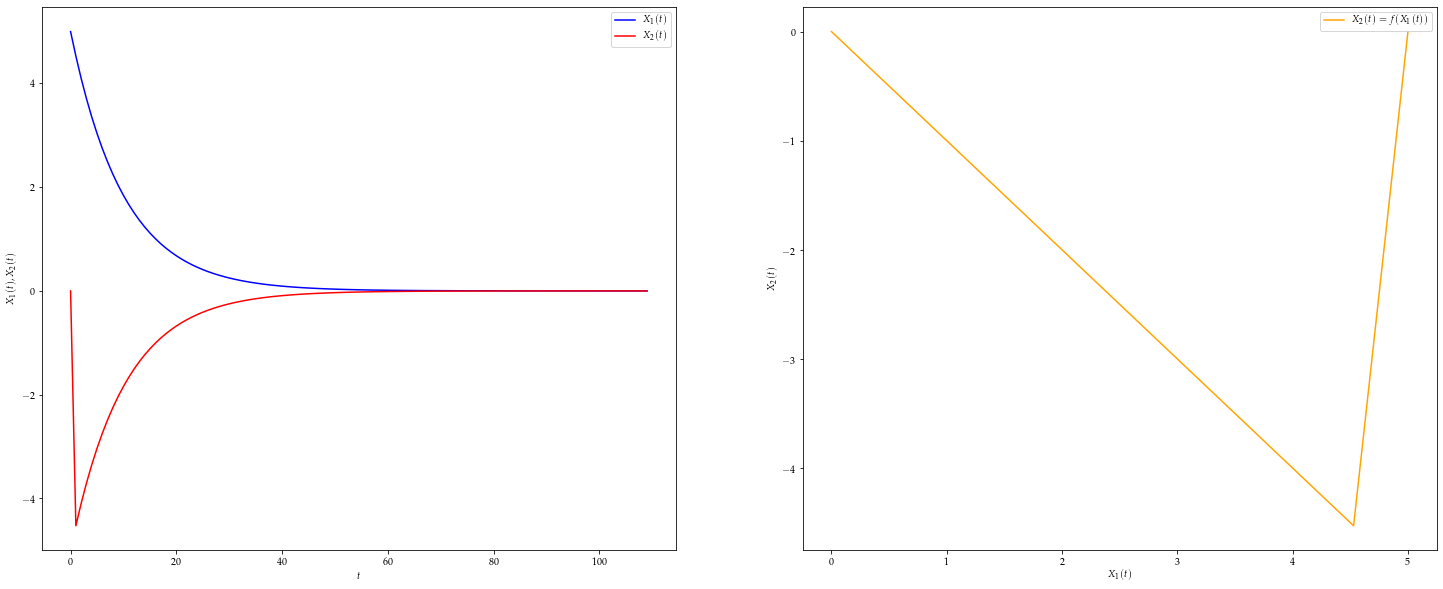

In [9]:
plt.figure(figsize=(25,10))
plt.subplot(121)
plt.plot(S[:,0],color='blue',label=r'$X_1(t)$')
plt.plot(S[:,1],color='red',label=r'$X_2(t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$X_1(t),X_2(t)$')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(S[:,0],S[:,1],label=r'$X_2(t)=f(X_1(t))$',color='orange')
plt.xlabel(r'$X_1(t)$')
plt.ylabel(r'$X_2(t)$')
plt.legend(loc='best')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/RINN-master/graphes/VDO_true_solution_odeint',dpi=300)

In [10]:
S.shape

(110, 2)

In [11]:
S.shape

(110, 2)

In [12]:
batch_size      = S.shape[0]
X_train = np.reshape(S,(int(S.shape[0]/batch_size),batch_size,S.shape[1]))
Y_train = np.reshape(S,(int(S.shape[0]/batch_size),batch_size,S.shape[1]))
print(X_train.shape)

(1, 110, 2)


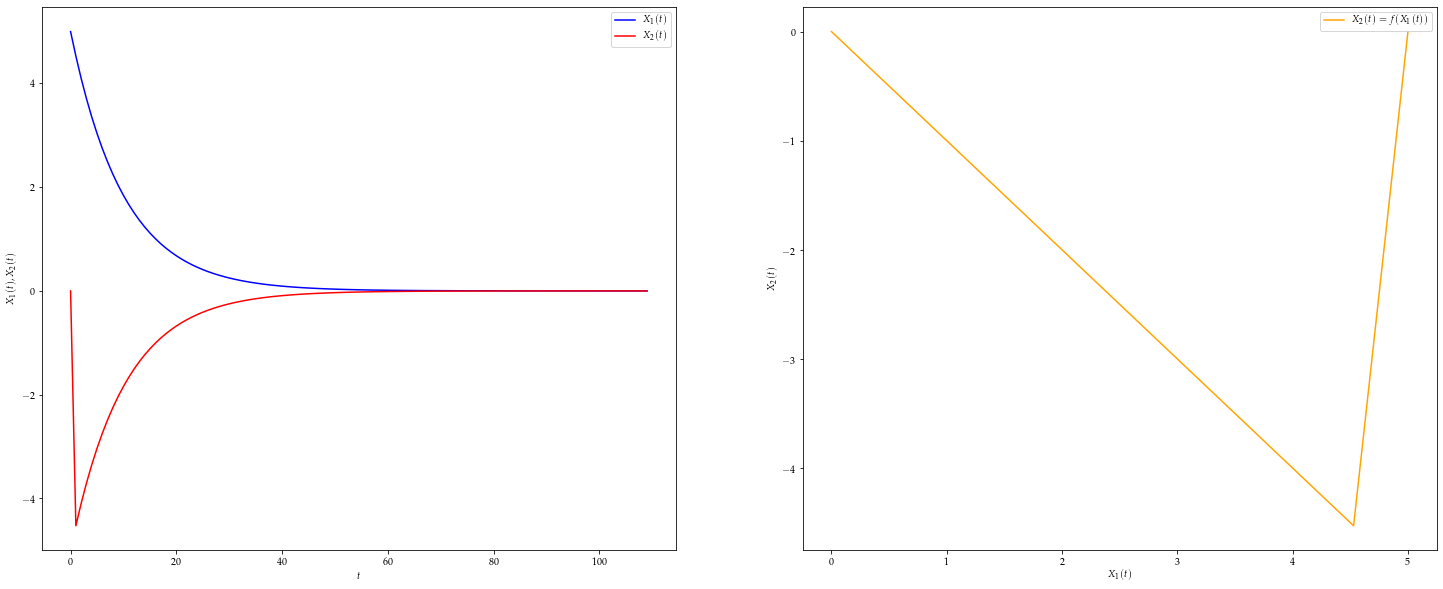

In [13]:
plt.figure(figsize=(25,10))
plt.subplot(121)
plt.plot(X_train[0,:,0],color='blue',label=r'$X_1(t)$')
plt.plot(X_train[0,:,1],color='red',label=r'$X_2(t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$X_1(t),X_2(t)$')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(X_train[0,:,0],X_train[0,:,1],label=r'$X_2(t)=f(X_1(t))$',color='orange')
plt.xlabel(r'$X_1(t)$')
plt.ylabel(r'$X_2(t)$')
plt.legend(loc='best')

In [14]:
# generating training data
class GD2:
    model = 'Adv_Dif_1D_Real'
    class parameters:
        w = -0.5
        x0 = 0.5
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 1000.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog2, xt2, yo2 = generate_data(GD2)
print(catalog2.true_solution.shape)
#AnDA_RMSE(catalog.true_solution,catalog.euler_integration)
#AnDA_RMSE(catalog.true_solution,catalog.num_integration)
#training data
batch_size_lin = catalog2.true_solution[:-10-1,:].shape[0]
X_train_lin = np.reshape(catalog2.true_solution[:-10-1,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))
Grad_t_lin  = np.reshape(np.gradient(catalog2.true_solution[:-10-1,0])/GD.dt_integration,(X_train_lin.shape))
Y_train_lin = np.reshape(catalog2.true_solution[1:-10,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))
print(X_train.shape)

(100011, 1)
(1, 110, 2)


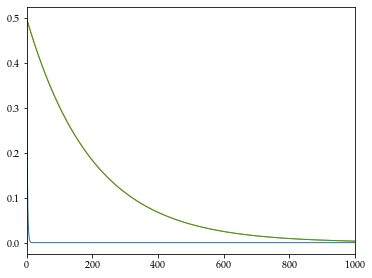

In [15]:
fig=plt.figure(figsize=(20,10))
plt.subplot(231)
plt.xlim([0,1000])
plt.plot(catalog2.time,catalog2.true_solution,linewidth=1)
plt.plot(X_train_lin[0,:,0],linewidth=1)
plt.plot(Y_train_lin[0,:,0],linewidth=1)

In [16]:
params = {}#NN parameters 
params['order'] = 4
params['transition_layers']=1
params['bi_linear_layers']=2
params['dim_hidden_linear'] = 2
params['dim_input']=2
params['dim_observations'] = 2
params['dim_output']=2
params['dim_hidden']=2
params['dt_integration']=GD.dt_integration
params['ntrain']=[3000,0]
params['lr']=0.01
pretrained = False
path = 'Implicit_On_Linear_Stiff_identification.pt'

In [17]:
def jacobian_in_batch(y, x):
    '''
    Compute the Jacobian matrix in batch form.
    Return (B, D_y, D_x)
    '''

    batch = y.shape[0]
    single_y_size = np.prod(y.shape[1:])
    y = y.view(batch, -1)
    vector = torch.ones(batch).to(y)

    # Compute Jacobian row by row.
    # dy_i / dx -> dy / dx
    # (B, D) -> (B, 1, D) -> (B, D, D)
    jac = [torch.autograd.grad(y[:, i], x, 
                               grad_outputs=vector, 
                               retain_graph=True,
                               create_graph=True,
                               allow_unused=True)[0].view(batch, -1)
                for i in range(single_y_size)]
    jac = torch.stack(jac, dim=1)
    
    return jac
def kron(a, b):
    """
    Kronecker product of matrices a and b with leading batch dimensions.
    Batch dimensions are broadcast. The number of them mush
    :type a: torch.Tensor
    :type b: torch.Tensor
    :rtype: torch.Tensor
    """
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)

# Learn dynamical and integration models, stop when loss ~ 0.2

In [18]:
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
class FC_net_true(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true, self).__init__()
            self.mu = GD.parameters.mu
        def forward(self, inp):
            grad = Variable(torch.zeros((inp.size())))
            grad[:,0] = inp[:,0]#(1/self.eps)*(self.q*inp[:,1]-inp[:,0]*inp[:,1] +inp[:,0]*(1-inp[:,0]));
            grad[:,1] = -1000*inp[:,0]-1001*inp[:,1]#self.mu*(1-inp[:,0]**2)*inp[:,1] -inp[:,0]#(1/self.eps2)*(-self.q*inp[:,1]-inp[:,1]*inp[:,0]+self.f*inp[:,2]);
            return grad
model_true  = FC_net_true(params)

class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear'],bias=False)#supprimer biais, vérifier dimensions 2x2

           
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            L_outp   = self.linearCell(inp)
            return L_outp
            
model  = FC_net(params)

class FC_net_lin(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_lin, self).__init__()
            self.coef_mdl =GD2.parameters.w
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            grad = self.coef_mdl*inp
            return grad
model_lin  = FC_net_lin(params)
class INT_net(torch.nn.Module):
        def __init__(self, params,order):
            super(INT_net, self).__init__()
            self.Dyn_net = model#model
            self.Dyn_net_lin = model_lin
            self.Dyn_net_True = model_true
            a = np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = np.random.uniform(size=(1,order))
            c = np.random.uniform(size=(1,order))
            self.a = torch.nn.Parameter(torch.from_numpy(a[:,:,:]).float(),requires_grad = True)
            self.b = torch.nn.Parameter(torch.from_numpy(b).float(),requires_grad = True)
            self.c = torch.nn.Parameter(torch.from_numpy(c).float(),requires_grad = True)
        def lin_flow(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_lin(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_lin(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
        def flow_True_Model(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_True(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_True(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp
        def flow_RK45_True_Model(self, inp,dt,order = 4):
            k1    = self.Dyn_net_True(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_True(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_True(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_True(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1        
        def flow_RK45(self, inp,dt,order = 4):
            k1    = self.Dyn_net(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1        
        def opti_gain_lin(self, h_int, inp, order):
            gain = Variable(torch.zeros(h_int.size()).float())
            for i in range(h_int.shape[0]):
                pred ,tmp, tmpp =self.lin_flow(inp, h_int[i], order)
                gain[i] = tmpp[0]
                del pred, tmp, tmpp
            return gain
        
        def Linear_newton_method_solver(self,function, initial,inp,dt,order, iteration=20, convergence=0.00000001):
            for i in range(iteration): 
                previous_data = initial.clone()
                value = function(initial,inp,dt,order)
                
                jacs = jacobian_in_batch(self.Dyn_net(inp), inp)#, 2, 3, verbose=1)
                inc = torch.bmm(torch.inverse(torch.eye(initial.shape[-1]).unsqueeze(0).repeat(initial.shape[0],1,1)-dt*kron(self.a.repeat(jacs.shape[0],1,1),jacs)),value.unsqueeze(-1)).squeeze(-1) 
                # update 
                initial = initial + inc
                # zero out current gradient to hold new gradients in next iteration 
                #initial.grad.data.zero_() 
                # Check convergence. 
                # When difference current epoch result and previous one is less than 
                # convergence factor, return result.
                if torch.abs(initial - previous_data).sum() < torch.tensor(convergence):
                    return initial
            return initial # return our final after iteration                
        
        
        def newton_method_solver(self,function, initial,inp,dt,order, iteration=20, convergence=0.00000001):
            for i in range(iteration): 
                print('iteration ', i)
                previous_data = initial.clone()
                value = function(initial,inp,dt,order)
                jacs = jacobian_in_batch(value, initial)#, 2, 3, verbose=1)
                # update 
                initial = initial - torch.bmm(torch.inverse(jacs),value.unsqueeze(2)).squeeze(-1)#(value / initial.grad).data
                # zero out current gradient to hold new gradients in next iteration 
                #initial.grad.data.zero_() 
                # Check convergence. 
                # When difference current epoch result and previous one is less than 
                # convergence factor, return result.
                if torch.abs(initial - previous_data).sum() < torch.tensor(convergence):
                    return initial
            return initial # return our final after iteration
        
        
        def solve_function(self, kin, inp, dt, order):
            zin = inp.unsqueeze(1).repeat(1, order, 1).reshape(inp.shape[0],-1)
            fin = torch.zeros_like(zin)
            for i in range(order):
                fin[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]] = (self.Dyn_net(kin[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]]))
            all_in = zin - kin + torch.bmm(dt*(kron(self.a,torch.eye(inp.shape[-1]).unsqueeze(0))).repeat(fin.shape[0],1,1),fin.unsqueeze(-1)).squeeze(-1)           
            return all_in
        
        
        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.zeros(k[0].size())
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            #self.a.data[0,:,0] = self.c[0,:] - self.a[:,:,1:].sum(dim = 2)
            k_init = torch.ones_like(torch.stack(k).permute(1,0,2).reshape(inp.shape[0],-1))
            k_opti = self.Linear_newton_method_solver(self.solve_function, k_init,inp,dt,order, iteration=20, convergence=0.0000001)
            #print(k_opti[:,:6])
            pred_sum = torch.autograd.Variable(torch.zeros(inp.size()))
            for i in range(0,order):
                pred_sum = pred_sum+self.Dyn_net(k_opti[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]])*self.b[0,i].expand_as(k_opti[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/inp[0,:]
            return pred ,k_opti, gain 


class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
            if hasattr(module, 'a'):
                module.a.data[0,:,0] = module.c.data[0,:] - module.a.data[:,:,1:].sum(dim = 2)


In [19]:
x = Variable(torch.from_numpy(X_train).float())
y = Variable(torch.from_numpy(Y_train).float())

x_lin = Variable(torch.from_numpy(X_train_lin).float())
y_lin = Variable(torch.from_numpy(Y_train_lin).float())

hi = np.arange(0,5.0+0.000001,0.01)
h_int = Variable(torch.from_numpy(hi).float())
gain_true = Variable(torch.from_numpy(np.ones_like(h_int)).float())

# Construct our model by instantiating the class defined above
   
modelRINN = INT_net(params,params['order'])
    # Construct our loss function and an Optimizer. The call to model.parameters()

if pretrained :
       modelRINN.load_state_dict(torch.load(path))
criterion = torch.nn.MSELoss()
def customized_loss(x, y):
        gain_to_zero = ((x-y))**2
        return torch.mean(gain_to_zero)
optimizer = torch.optim.Adam(modelRINN.parameters(), lr = 0.1)
clipper = applyRK_Constraints()

def gradClamp(parameters, clip=5):
    for p in parameters:
        if type(p.grad) !=type(None):
            p.grad.data.clamp_(min = -clip,max=clip)

In [20]:
optimizer = torch.optim.Adam(modelRINN.parameters(), lr = params['lr'])
#Scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.99, patience=100, threshold=0.001, threshold_mode='abs',min_lr=1e-6)
#Scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1, last_epoch=-1, verbose=False)
#Scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, eta_min=0, last_epoch=-1, verbose=False)

In [21]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def delta(x):
  if x==0:
    return 1
  return 0

epsilon=1e-6

def adjust_learning_rate(optimizer, epoch):
  
  current_lr=get_lr(optimizer)
  new_lr=params['lr']*(1+np.cos(epoch/200*np.pi))+epsilon#+params['lr']*delta(epoch%100)+epsilon
  for param_group in optimizer.param_groups:
      param_group['lr'] = new_lr


In [22]:
def burst_sampling(x,dt = 0.1,ns = 8,nb = 20):
    burst_sample = [x[0,:ns,:]]
    for i in range(nb):
        sampling_location = np.random.randint(0, x.shape[1]-ns)
        burst_sample.append(x[0,sampling_location:sampling_location+ns,:])
    burst_sample = torch.stack(burst_sample)
    return burst_sample[:,:-1,:],burst_sample[:,1:,:]

In [ ]:
from tqdm import tqdm

ParamsList=[]
LossList=[]
MatricesList=[]
LearningRatesList=[]
SelectedBatchs=[]

print ('Learning dynamical model')
tmpx,tmpy = burst_sampling(x)
Batch=tmpx.shape[0]
Index=[i for i in range(Batch)]

BinaryVar=0
maxLoss=1e9
t=0
for t in tqdm(range(params['ntrain'][0])):

        maxLoss=0
        

        for b in Index:
            #b = 0
            tmpx.requires_grad = True
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(tmpx[b,:,:],params['dt_integration'],params['order'])
            pred2 ,grad , inp = modelRINN(pred,params['dt_integration'],params['order'])
            pred3 ,grad , inp = modelRINN(pred2,params['dt_integration'],params['order'])
            pred4 ,grad , inp = modelRINN(pred3,params['dt_integration'],params['order'])
            # Compute and print loss
            loss = criterion(pred[np.where(~np.isnan(pred.data.numpy()))], tmpy[b,:,:][np.where(~np.isnan(pred.data.numpy()))])#+criterion(pred2[:-1,:], pred[1:,:])+criterion(pred3[:-1,:], pred2[1:,:])+criterion(pred4[:-1,:], pred3[1:,:])
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            gradClamp(modelRINN.parameters())
            optimizer.step()
            modelRINN.apply(clipper)
            
            torch.save(modelRINN.state_dict(), 'Implicit_On_Linear_Stiff_identification.pt')
            print(t,b,loss.detach().numpy())
            #Scheduler.step(loss)

            if loss.detach().numpy()<1e-3:
              Index.remove(b)
       
            
            if loss.detach().numpy()>maxLoss:
              maxLoss=loss.detach().numpy()

        adjust_learning_rate(optimizer,t)
              
        a=modelRINN.a.clone().detach()
        b=modelRINN.b.clone().detach()
        c=modelRINN.c.clone().detach()
        M=modelRINN.Dyn_net.linearCell.weight.clone().detach().numpy()
        ParamsList.append([a,b,c,M])
        LearningRatesList.append(get_lr(optimizer))
        LossList.append(maxLoss)
        SelectedBatchs.append(len(Index))
        #print(ParamsList)
        #print(MatricesList)
        #if maxLoss<1e-3:
          #break
        
        print(t,"maxLoss={}".format(maxLoss),'lr=',get_lr(optimizer))

  0%|          | 0/3000 [00:00<?, ?it/s]

Learning dynamical model
0 0 1.7764513
0 1 0.0002761451
0 3 0.022264734
0 4 1.9978228e-05
0 6 1.088061e-07
0 8 1.7887816e-10
0 10 7.884688e-07
0 12 5.8118538e-08
0 14 9.4457486e-05
0 16 2.3158955e-05


  0%|          | 1/3000 [00:00<25:59,  1.92it/s]

0 18 0.00279982
0 19 8.474308e-08
0 maxLoss=1.7764513492584229 lr= 0.020001
1 0 1.5970938
1 2 3.6692502e-06
1 5 8.928678e-11
1 9 1.4351977e-09


  0%|          | 2/3000 [00:00<22:09,  2.25it/s]

1 13 0.00092856504
1 17 6.839469e-09
1 20 0.00060068385
1 maxLoss=1.5970938205718994 lr= 0.019999766324816606
2 0 1.5820494
2 3 0.017184047
2 7 0.0014993291
2 11 1.625711e-10


  0%|          | 3/3000 [00:01<22:00,  2.27it/s]

2 18 0.0020837758
2 maxLoss=1.5820493698120117 lr= 0.01999606560365732
3 0 1.5695016
3 3 0.014259493


  0%|          | 4/3000 [00:01<21:35,  2.31it/s]

3 7 0.0012291936
3 15 9.739292e-10
3 maxLoss=1.5695016384124756 lr= 0.019989898749619702
4 0 1.558101
4 3 0.011708299


  0%|          | 5/3000 [00:01<19:18,  2.59it/s]

4 7 0.0010009151
4 18 0.0014119353
4 maxLoss=1.5581010580062866 lr= 0.019981267284282716
5 0 1.5460914


  0%|          | 6/3000 [00:02<19:00,  2.63it/s]

5 3 0.009321706
5 7 0.0007926007
5 maxLoss=1.5460914373397827 lr= 0.019970173337331282
6 0 1.5366907
6 3 0.007708615


  0%|          | 7/3000 [00:02<20:12,  2.47it/s]

6 18 0.00097383687
6 maxLoss=1.5366907119750977 lr= 0.0199566196460308


  0%|          | 8/3000 [00:03<20:09,  2.47it/s]

7 0 1.5269296
7 3 0.0063178227
7 maxLoss=1.5269296169281006 lr= 0.0199406095545518
8 0 1.5200586


  0%|          | 9/3000 [00:03<22:34,  2.21it/s]

8 3 0.0055133635
8 maxLoss=1.5200586318969727 lr= 0.01992214701314478


  0%|          | 10/3000 [00:04<23:23,  2.13it/s]

9 0 1.5127147
9 3 0.004818239
9 maxLoss=1.5127147436141968 lr= 0.01990123657716558


  0%|          | 11/3000 [00:04<21:48,  2.28it/s]

10 0 1.5050882
10 3 0.0042465674
10 maxLoss=1.505088210105896 lr= 0.01987788340595138


  0%|          | 12/3000 [00:04<19:25,  2.56it/s]

11 0 1.4973068
11 3 0.003795926
11 maxLoss=1.4973068237304688 lr= 0.01985209326154774
12 0 1.4894522
12

  0%|          | 13/3000 [00:05<19:33,  2.55it/s]

 3 0.003452519
12 maxLoss=1.4894522428512573 lr= 0.01982387250728689
13 0 1.4815711


  0%|          | 14/3000 [00:05<17:24,  2.86it/s]

13 3 0.0031961103
13 maxLoss=1.481571078300476 lr= 0.01979322810621766
14 0 1.4736863


  0%|          | 15/3000 [00:05<18:42,  2.66it/s]

14 3 0.0030042795
14 maxLoss=1.4736863374710083 lr= 0.019760167619387477
15 0 1.4658091


  1%|          | 16/3000 [00:06<18:58,  2.62it/s]

15 3 0.0028557759
15 maxLoss=1.4658091068267822 lr= 0.019724699203976768


  1%|          | 17/3000 [00:06<20:27,  2.43it/s]

16 0 1.4579427
16 3 0.0027327798
16 maxLoss=1.4579427242279053 lr= 0.01968683161128631


  1%|          | 18/3000 [00:07<20:03,  2.48it/s]

17 0 1.450091
17 3 0.0026220658
17 maxLoss=1.450091004371643 lr= 0.01964657418457798


  1%|          | 19/3000 [00:07<19:19,  2.57it/s]

18 0 1.4422579
18 3 0.0025152822
18 maxLoss=1.4422578811645508 lr= 0.019603936856769432
19 0 1.4344518


  1%|          | 20/3000 [00:08<27:36,  1.80it/s]

19 3 0.0024084202
19 maxLoss=1.4344518184661865 lr= 0.0195589301479833
20 0 1.4266833


  1%|          | 21/3000 [00:09<32:03,  1.55it/s]

20 3 0.0023009484
20 maxLoss=1.4266833066940308 lr= 0.01951156516295154
21 0 1.4189651


  1%|          | 22/3000 [00:10<39:39,  1.25it/s]

21 3 0.0021946807
21 maxLoss=1.4189651012420654 lr= 0.019461853588275454
22 0 1.4113106


  1%|          | 23/3000 [00:11<39:03,  1.27it/s]

22 3 0.0020927233
22 maxLoss=1.4113105535507202 lr= 0.019409807689542258
23 0 1.4037343


  1%|          | 24/3000 [00:12<40:19,  1.23it/s]

23 3 0.0019985528
23 maxLoss=1.4037343263626099 lr= 0.019355440308298676
24 0 1.3962471


  1%|          | 25/3000 [00:13<41:13,  1.20it/s]

24 3 0.0019153414
24 maxLoss=1.396247148513794 lr= 0.019298764858882513
25 0 1.3888606


  1%|          | 26/3000 [00:13<40:10,  1.23it/s]

25 3 0.0018455401
25 maxLoss=1.3888605833053589 lr= 0.019239795325112868
26 0 1.3815831


  1%|          | 27/3000 [00:14<41:20,  1.20it/s]

26 3 0.0017906834
26 maxLoss=1.3815830945968628 lr= 0.01917854625683981
27 0 1.3744205


  1%|          | 28/3000 [00:15<42:25,  1.17it/s]

27 3 0.0017513916
27 maxLoss=1.3744205236434937 lr= 0.019115032766354453
28 0 1.3673785


  1%|          | 29/3000 [00:16<39:01,  1.27it/s]

28 3 0.001727505
28 maxLoss=1.3673784732818604 lr= 0.019049270524660197
29 0 1.3604604


  1%|          | 30/3000 [00:17<43:41,  1.13it/s]

29 3 0.0017182564
29 maxLoss=1.3604604005813599 lr= 0.018981275757606157
30 0 1.353669


  1%|          | 31/3000 [00:18<44:31,  1.11it/s]

30 3 0.0017225266
30 maxLoss=1.3536690473556519 lr= 0.01891106524188368
31 0 1.3470061


  1%|          | 32/3000 [00:19<44:33,  1.11it/s]

31 3 0.0017390286
31 maxLoss=1.34700608253479 lr= 0.018838656300886936
32 0 1.3404747


  1%|          | 33/3000 [00:20<45:37,  1.08it/s]

32 3 0.0017664877
32 maxLoss=1.3404747247695923 lr= 0.018764066800438635
33 0 1.3340766


  1%|          | 34/3000 [00:20<43:43,  1.13it/s]

33 3 0.0018038208
33 maxLoss=1.3340766429901123 lr= 0.018687315144381916
34 0 1.3278148


  1%|          | 35/3000 [00:21<45:00,  1.10it/s]

34 3 0.0018501963
34 maxLoss=1.3278148174285889 lr= 0.01860842027003944
35 0 1.3216915


  1%|          | 36/3000 [00:22<44:16,  1.12it/s]

35 3 0.0019051416
35 maxLoss=1.3216915130615234 lr= 0.018527401643540924
36 0 1.3157082


  1%|          | 37/3000 [00:23<42:18,  1.17it/s]

36 3 0.0019685843
36 maxLoss=1.3157081604003906 lr= 0.018444279255020152
37 0 1.3098634


  1%|▏         | 38/3000 [00:24<45:49,  1.08it/s]

37 3 0.0020408903
37 maxLoss=1.3098634481430054 lr= 0.018359073613682705
38 0 1.3041544


  1%|▏         | 39/3000 [00:25<45:16,  1.09it/s]

38 3 0.0021228634
38 maxLoss=1.304154396057129 lr= 0.018271805742745617
39 0 1.2985717


  1%|▏         | 40/3000 [00:26<45:42,  1.08it/s]

39 3 0.002215856
39 maxLoss=1.2985717058181763 lr= 0.018182497174250235
40 0 1.2931031


  1%|▏         | 41/3000 [00:27<45:13,  1.09it/s]

40 3 0.0023217783
40 maxLoss=1.2931030988693237 lr= 0.018091169943749475
41 0 1.2877263


  1%|▏         | 42/3000 [00:28<47:44,  1.03it/s]

41 3 0.002443303
41 maxLoss=1.2877262830734253 lr= 0.01799784658487091
42 0 1.282411


  1%|▏         | 43/3000 [00:29<46:36,  1.06it/s]

42 3 0.0025839861
42 maxLoss=1.282410979270935 lr= 0.017902550123756907
43 0 1.2771165


  1%|▏         | 44/3000 [00:30<45:23,  1.09it/s]

43 3 0.0027484975
43 maxLoss=1.2771165370941162 lr= 0.017805304073383297
44 0 1.2717904


  2%|▏         | 45/3000 [00:31<47:14,  1.04it/s]

44 3 0.0029427826
44 maxLoss=1.2717903852462769 lr= 0.017706132427757895
45 0 1.2663723


  2%|▏         | 46/3000 [00:32<46:02,  1.07it/s]

45 3 0.0031741154
45 maxLoss=1.2663723230361938 lr= 0.017605059656000312
46 0 1.2607995


  2%|▏         | 47/3000 [00:33<46:58,  1.05it/s]

46 3 0.0034507192
46 maxLoss=1.260799527168274 lr= 0.0175021106963046
47 0 1.2550166


  2%|▏         | 48/3000 [00:34<46:23,  1.06it/s]

47 3 0.0037807557
47 maxLoss=1.255016565322876 lr= 0.0173973109497861
48 0 1.2489947


  2%|▏         | 49/3000 [00:34<45:48,  1.07it/s]

48 3 0.0041703223
48 maxLoss=1.2489947080612183 lr= 0.017290686274214116
49 0 1.2427381


  2%|▏         | 50/3000 [00:35<47:25,  1.04it/s]

49 3 0.0046205926
49 maxLoss=1.242738127708435 lr= 0.01718226297763189
50 0 1.2362967


  2%|▏         | 51/3000 [00:36<46:36,  1.05it/s]

50 3 0.005124888
50 maxLoss=1.2362966537475586 lr= 0.017072067811865477
51 0 1.2297547


  2%|▏         | 52/3000 [00:37<47:36,  1.03it/s]

51 3 0.005666792
51 maxLoss=1.2297546863555908 lr= 0.016960127965923142
52 0 1.2232133


  2%|▏         | 53/3000 [00:38<46:11,  1.06it/s]

52 3 0.0062209857
52 maxLoss=1.2232133150100708 lr= 0.01684647105928689
53 0 1.2167643


  2%|▏         | 54/3000 [00:39<47:09,  1.04it/s]

53 3 0.0067568673
53 maxLoss=1.2167643308639526 lr= 0.016731125135097735
54 0 1.2104743


  2%|▏         | 55/3000 [00:40<45:59,  1.07it/s]

54 3 0.007244304
54 maxLoss=1.2104742527008057 lr= 0.01661411865323652
55 0 1.2043755


  2%|▏         | 56/3000 [00:41<45:19,  1.08it/s]

55 3 0.0076593603
55 maxLoss=1.2043755054473877 lr= 0.016495480483301836
56 0 1.198474


  2%|▏         | 57/3000 [00:42<45:58,  1.07it/s]

56 3 0.007988225
56 maxLoss=1.1984740495681763 lr= 0.016375239897486897
57 0 1.1927598


  2%|▏         | 58/3000 [00:43<45:07,  1.09it/s]

57 3 0.0082283635
57 maxLoss=1.1927597522735596 lr= 0.016253426563357057
58 0 1.1872176


  2%|▏         | 59/3000 [00:44<47:55,  1.02it/s]

58 3 0.008387456
58 maxLoss=1.1872175931930542 lr= 0.01613007053652977
59 0 1.1818317


  2%|▏         | 60/3000 [00:45<47:27,  1.03it/s]

59 3 0.008480684
59 maxLoss=1.18183171749115 lr= 0.016005202253258844
60 0 1.1765863


  2%|▏         | 61/3000 [00:46<46:44,  1.05it/s]

60 3 0.008527835
60 maxLoss=1.1765862703323364 lr= 0.015878852522924734
61 0 1.1714642


  2%|▏         | 62/3000 [00:47<46:55,  1.04it/s]

61 3 0.008550263
61 maxLoss=1.171464204788208 lr= 0.01575105252043279
62 0 1.1664455


  2%|▏         | 63/3000 [00:48<46:41,  1.05it/s]

62 3 0.008568521
62 maxLoss=1.1664454936981201 lr= 0.015621833778521305
63 0 1.161506


  2%|▏         | 64/3000 [00:49<48:11,  1.02it/s]

63 3 0.00860058
63 maxLoss=1.1615060567855835 lr= 0.015491228179981317
64 0 1.1566213


  2%|▏         | 65/3000 [00:50<46:43,  1.05it/s]

64 3 0.008660656
64 maxLoss=1.1566213369369507 lr= 0.015359267949789965
65 0 1.1517668


  2%|▏         | 66/3000 [00:51<49:34,  1.01s/it]

65 3 0.008758543
65 maxLoss=1.1517667770385742 lr= 0.015225985647159488
66 0 1.1469246


  2%|▏         | 67/3000 [00:52<48:11,  1.01it/s]

66 3 0.008899524
66 maxLoss=1.146924614906311 lr= 0.015091414157503712
67 0 1.1420827


  2%|▏         | 68/3000 [00:53<47:39,  1.03it/s]

67 3 0.009084642
67 maxLoss=1.142082691192627 lr= 0.014955586684324075
68 0 1.1372378


  2%|▏         | 69/3000 [00:54<46:59,  1.04it/s]

68 3 0.009311205
68 maxLoss=1.137237787246704 lr= 0.014818536741017152
69 0 1.1323937


  2%|▏         | 70/3000 [00:55<46:20,  1.05it/s]

69 3 0.009573652
69 maxLoss=1.132393717765808 lr= 0.014680298142605734
70 0 1.1275603


  2%|▏         | 71/3000 [00:56<48:24,  1.01it/s]

70 3 0.009864467
70 maxLoss=1.1275602579116821 lr= 0.014540904997395467
71 0 1.1227486


  2%|▏         | 72/3000 [00:57<46:56,  1.04it/s]

71 3 0.0101751955
71 maxLoss=1.122748613357544 lr= 0.014400391698559152
72 0 1.1179726


  2%|▏         | 73/3000 [00:58<47:39,  1.02it/s]

72 3 0.01049743
72 maxLoss=1.1179726123809814 lr= 0.014258792915650726
73 0 1.1132437


  2%|▏         | 74/3000 [00:59<47:24,  1.03it/s]

73 3 0.010823513
73 maxLoss=1.1132436990737915 lr= 0.014116143586051089
74 0 1.1085719


  2%|▎         | 75/3000 [00:59<46:16,  1.05it/s]

74 3 0.011147241
74 maxLoss=1.1085718870162964 lr= 0.013972478906347804
75 0 1.1039646


  3%|▎         | 76/3000 [01:01<47:20,  1.03it/s]

75 3 0.011464069
75 maxLoss=1.1039645671844482 lr= 0.013827834323650898
76 0 1.0994265


  3%|▎         | 77/3000 [01:01<46:16,  1.05it/s]

76 3 0.011771242
76 maxLoss=1.099426507949829 lr= 0.01368224552684678
77 0 1.0949603


  3%|▎         | 78/3000 [01:02<46:36,  1.04it/s]

77 3 0.012067704
77 maxLoss=1.094960331916809 lr= 0.013535748437792572
78 0 1.090567


  3%|▎         | 79/3000 [01:03<45:24,  1.07it/s]

78 3 0.012353728
78 maxLoss=1.0905669927597046 lr= 0.013388379202452916
79 0 1.0862457


  3%|▎         | 80/3000 [01:04<47:24,  1.03it/s]

79 3 0.012630657
79 maxLoss=1.0862456560134888 lr= 0.013240174181981494
80 0 1.0819947


  3%|▎         | 81/3000 [01:05<46:19,  1.05it/s]

80 3 0.012900456
80 maxLoss=1.081994652748108 lr= 0.013091169943749474
81 0 1.0778115


  3%|▎         | 82/3000 [01:06<45:37,  1.07it/s]

81 3 0.013165338
81 maxLoss=1.0778114795684814 lr= 0.012941403252323038
82 0 1.0736939


  3%|▎         | 83/3000 [01:07<47:49,  1.02it/s]

82 3 0.013427509
82 maxLoss=1.073693871498108 lr= 0.012790911060392294
83 0 1.0696393


  3%|▎         | 84/3000 [01:08<47:37,  1.02it/s]

83 3 0.013688899
83 maxLoss=1.0696393251419067 lr= 0.01263973049965373
84 0 1.0656457


  3%|▎         | 85/3000 [01:09<47:39,  1.02it/s]

84 3 0.013951024
84 maxLoss=1.065645694732666 lr= 0.012487898871648551
85 0 1.061712


  3%|▎         | 86/3000 [01:10<46:40,  1.04it/s]

85 3 0.014214924
85 maxLoss=1.0617120265960693 lr= 0.012335453638559054
86 0 1.0578371


  3%|▎         | 87/3000 [01:11<48:57,  1.01s/it]

86 3 0.01448117
86 maxLoss=1.0578371286392212 lr= 0.012182432413965426
87 0 1.0540209


  3%|▎         | 88/3000 [01:12<46:51,  1.04it/s]

87 3 0.01474986
87 maxLoss=1.054020881652832 lr= 0.012028872953565124
88 0 1.0502633


  3%|▎         | 89/3000 [01:13<45:38,  1.06it/s]

88 3 0.015020749
88 maxLoss=1.0502632856369019 lr= 0.011874813145857248
89 0 1.0465655


  3%|▎         | 90/3000 [01:14<46:31,  1.04it/s]

89 3 0.015293333
89 maxLoss=1.0465655326843262 lr= 0.011720291002794094
90 0 1.042928


  3%|▎         | 91/3000 [01:15<45:33,  1.06it/s]

90 3 0.015566888
90 maxLoss=1.0429279804229736 lr= 0.011565344650402308
91 0 1.0393522


  3%|▎         | 92/3000 [01:16<46:54,  1.03it/s]

91 3 0.015840625
91 maxLoss=1.0393521785736084 lr= 0.011410012319375825
92 0 1.0358387


  3%|▎         | 93/3000 [01:17<45:37,  1.06it/s]

92 3 0.016113723
92 maxLoss=1.0358387231826782 lr= 0.011254332335643042
93 0 1.0323888


  3%|▎         | 94/3000 [01:18<48:23,  1.00it/s]

93 3 0.016385423
93 maxLoss=1.0323888063430786 lr= 0.011098343110910451
94 0 1.0290035


  3%|▎         | 95/3000 [01:19<47:32,  1.02it/s]

94 3 0.016655026
94 maxLoss=1.0290035009384155 lr= 0.010942083133185145
95 0 1.0256829


  3%|▎         | 96/3000 [01:20<45:43,  1.06it/s]

95 3 0.016921965
95 maxLoss=1.0256829261779785 lr= 0.01078559095727845
96 0 1.0224277


  3%|▎         | 97/3000 [01:21<46:20,  1.04it/s]

96 3 0.017185789
96 maxLoss=1.0224276781082153 lr= 0.010628905195293133
97 0 1.0192384


  3%|▎         | 98/3000 [01:22<45:30,  1.06it/s]

97 3 0.017446166
97 maxLoss=1.0192383527755737 lr= 0.010472064507096425
98 0 1.0161145


  3%|▎         | 99/3000 [01:23<47:30,  1.02it/s]

98 3 0.017702853
98 maxLoss=1.0161144733428955 lr= 0.010315107590781282
99 0 1.0130564


  3%|▎         | 100/3000 [01:24<46:37,  1.04it/s]

99 3 0.017955707
99 maxLoss=1.0130563974380493 lr= 0.010158073173118207
100 0 1.0100635


  3%|▎         | 101/3000 [01:25<46:55,  1.03it/s]

100 3 0.018204674
100 maxLoss=1.0100635290145874 lr= 0.010001
101 0 1.0071355


  3%|▎         | 102/3000 [01:25<45:26,  1.06it/s]

101 3 0.01844973
101 maxLoss=1.0071355104446411 lr= 0.009843926826881795
102 0 1.004272


  3%|▎         | 103/3000 [01:26<44:28,  1.09it/s]

102 3 0.01869088
102 maxLoss=1.0042719841003418 lr= 0.009686892409218717
103 0 1.0014727


  3%|▎         | 104/3000 [01:27<46:20,  1.04it/s]

103 3 0.018928181
103 maxLoss=1.0014727115631104 lr= 0.009529935492903574
104 0 0.9987368


  4%|▎         | 105/3000 [01:28<46:10,  1.04it/s]

104 3 0.019161683
104 maxLoss=0.9987367987632751 lr= 0.009373094804706866
105 0 0.9960639


  4%|▎         | 106/3000 [01:29<47:50,  1.01it/s]

105 3 0.019391391
105 maxLoss=0.9960638880729675 lr= 0.009216409042721552
106 0 0.9934537


  4%|▎         | 107/3000 [01:30<46:21,  1.04it/s]

106 3 0.019617392
106 maxLoss=0.9934536814689636 lr= 0.009059916866814855
107 0 0.99090546


  4%|▎         | 108/3000 [01:31<46:40,  1.03it/s]

107 3 0.019839657
107 maxLoss=0.9909054636955261 lr= 0.008903656889089546
108 0 0.98841846


  4%|▎         | 109/3000 [01:32<48:31,  1.01s/it]

108 3 0.020058226
108 maxLoss=0.988418459892273 lr= 0.008747667664356956
109 0 0.98599243


  4%|▎         | 110/3000 [01:33<46:41,  1.03it/s]

109 3 0.020273058
109 maxLoss=0.985992431640625 lr= 0.008591987680624174
110 0 0.9836269


  4%|▎         | 111/3000 [01:34<47:31,  1.01it/s]

110 3 0.02048417
110 maxLoss=0.9836269021034241 lr= 0.008436655349597689
111 0 0.9813209


  4%|▎         | 112/3000 [01:35<45:52,  1.05it/s]

111 3 0.02069151
111 maxLoss=0.9813209176063538 lr= 0.008281708997205903
112 0 0.9790746


  4%|▍         | 113/3000 [01:36<45:52,  1.05it/s]

112 3 0.020895064
112 maxLoss=0.9790745973587036 lr= 0.008127186854142751
113 0 0.9768866


  4%|▍         | 114/3000 [01:37<44:49,  1.07it/s]

113 3 0.021094773
113 maxLoss=0.9768865704536438 lr= 0.007973127046434877
114 0 0.9747564


  4%|▍         | 115/3000 [01:38<43:52,  1.10it/s]

114 3 0.021290617
114 maxLoss=0.9747564196586609 lr= 0.007819567586034576
115 0 0.9726842


  4%|▍         | 116/3000 [01:39<46:18,  1.04it/s]

115 3 0.021482527
115 maxLoss=0.9726842045783997 lr= 0.00766654636144095
116 0 0.97066796


  4%|▍         | 117/3000 [01:40<45:39,  1.05it/s]

116 3 0.021670517
116 maxLoss=0.9706679582595825 lr= 0.007514101128351454
117 0 0.96870786


  4%|▍         | 118/3000 [01:41<45:30,  1.06it/s]

117 3 0.021854516
117 maxLoss=0.9687078595161438 lr= 0.007362269500346274
118 0 0.96680266


  4%|▍         | 119/3000 [01:42<44:26,  1.08it/s]

118 3 0.022034543
118 maxLoss=0.9668026566505432 lr= 0.0072110889396077085
119 0 0.96495193


  4%|▍         | 120/3000 [01:43<44:33,  1.08it/s]

119 3 0.022210514
119 maxLoss=0.9649519324302673 lr= 0.007060596747676962
120 0 0.96315473


  4%|▍         | 121/3000 [01:44<44:47,  1.07it/s]

120 3 0.022382472
120 maxLoss=0.9631547331809998 lr= 0.0069108300562505266
121 0 0.96141005


  4%|▍         | 122/3000 [01:44<43:42,  1.10it/s]

121 3 0.02255038
121 maxLoss=0.9614100456237793 lr= 0.006761825818018508
122 0 0.9597176


  4%|▍         | 123/3000 [01:46<47:44,  1.00it/s]

122 3 0.022714276
122 maxLoss=0.9597175717353821 lr= 0.006613620797547086
123 0 0.9580756


  4%|▍         | 124/3000 [01:46<45:54,  1.04it/s]

123 3 0.022874117
123 maxLoss=0.9580755829811096 lr= 0.006466251562207431
124 0 0.9564838


  4%|▍         | 125/3000 [01:47<46:27,  1.03it/s]

124 3 0.023029957
124 maxLoss=0.956483781337738 lr= 0.006319754473153221
125 0 0.9549408


  4%|▍         | 126/3000 [01:48<45:44,  1.05it/s]

125 3 0.023181798
125 maxLoss=0.9549407958984375 lr= 0.006174165676349103
126 0 0.9534462


  4%|▍         | 127/3000 [01:49<44:51,  1.07it/s]

126 3 0.02332966
126 maxLoss=0.9534462094306946 lr= 0.006029521093652195
127 0 0.95199865


  4%|▍         | 128/3000 [01:50<48:05,  1.00s/it]

127 3 0.023473592
127 maxLoss=0.9519986510276794 lr= 0.0058858564139489125
128 0 0.9505974


  4%|▍         | 129/3000 [01:51<46:40,  1.03it/s]

128 3 0.023613628
128 maxLoss=0.9505974054336548 lr= 0.005743207084349273
129 0 0.9492416


  4%|▍         | 130/3000 [01:52<48:42,  1.02s/it]

129 3 0.023749767
129 maxLoss=0.949241578578949 lr= 0.005601608301440848
130 0 0.9479297


  4%|▍         | 131/3000 [01:53<46:49,  1.02it/s]

130 3 0.023882067
130 maxLoss=0.9479296803474426 lr= 0.005461095002604533
131 0 0.94666135


  4%|▍         | 132/3000 [01:54<47:20,  1.01it/s]

131 3 0.0240106
131 maxLoss=0.9466613531112671 lr= 0.005321701857394268
132 0 0.9454356


  4%|▍         | 133/3000 [01:55<45:48,  1.04it/s]

132 3 0.02413539
132 maxLoss=0.9454355835914612 lr= 0.005183463258982846
133 0 0.9442507


  4%|▍         | 134/3000 [01:56<46:42,  1.02it/s]

133 3 0.024256459
133 maxLoss=0.9442507028579712 lr= 0.005046413315675924
134 0 0.94310683


  4%|▍         | 135/3000 [01:57<45:59,  1.04it/s]

134 3 0.024373893
134 maxLoss=0.9431068301200867 lr= 0.0049105858424962874
135 0 0.9420024


  5%|▍         | 136/3000 [01:58<44:50,  1.06it/s]

135 3 0.02448777
135 maxLoss=0.9420024156570435 lr= 0.004776014352840512
136 0 0.94093615


  5%|▍         | 137/3000 [01:59<45:36,  1.05it/s]

136 3 0.024598066
136 maxLoss=0.9409361481666565 lr= 0.0046427320502100316
137 0 0.93990785


  5%|▍         | 138/3000 [02:00<44:27,  1.07it/s]

137 3 0.024704928
137 maxLoss=0.9399078488349915 lr= 0.004510771820018681
138 0 0.9389165


  5%|▍         | 139/3000 [02:01<45:27,  1.05it/s]

138 3 0.024808336
138 maxLoss=0.9389165043830872 lr= 0.004380166221478697
139 0 0.9379607


  5%|▍         | 140/3000 [02:02<44:34,  1.07it/s]

139 3 0.024908379
139 maxLoss=0.937960684299469 lr= 0.004250947479567218
140 0 0.9370397


  5%|▍         | 141/3000 [02:03<43:50,  1.09it/s]

140 3 0.025005098
140 maxLoss=0.9370396733283997 lr= 0.00412314747707527
141 0 0.936153


  5%|▍         | 142/3000 [02:04<44:50,  1.06it/s]

141 3 0.025098566
141 maxLoss=0.936152994632721 lr= 0.003996797746741161
142 0 0.9352993


  5%|▍         | 143/3000 [02:05<44:03,  1.08it/s]

142 3 0.025188858
142 maxLoss=0.935299277305603 lr= 0.0038719294634702375
143 0 0.93447787


  5%|▍         | 144/3000 [02:06<44:05,  1.08it/s]

143 3 0.025276002
143 maxLoss=0.9344778656959534 lr= 0.0037485734366429517
144 0 0.93368804


  5%|▍         | 145/3000 [02:06<43:16,  1.10it/s]

144 3 0.025360104
144 maxLoss=0.9336880445480347 lr= 0.0036267601025131027
145 0 0.9329285


  5%|▍         | 146/3000 [02:07<42:46,  1.11it/s]

145 3 0.025441198
145 maxLoss=0.9329285025596619 lr= 0.0035065195166981648
146 0 0.93219906


  5%|▍         | 147/3000 [02:08<44:20,  1.07it/s]

146 3 0.025519308
146 maxLoss=0.9321990609169006 lr= 0.003387881346763483
147 0 0.9314982


  5%|▍         | 148/3000 [02:09<44:10,  1.08it/s]

147 3 0.025594512
147 maxLoss=0.9314982295036316 lr= 0.003270874864902269
148 0 0.9308258


  5%|▍         | 149/3000 [02:10<45:33,  1.04it/s]

148 3 0.02566692
148 maxLoss=0.9308258295059204 lr= 0.0031555289407131128
149 0 0.9301806


  5%|▌         | 150/3000 [02:11<44:41,  1.06it/s]

149 3 0.02573655
149 maxLoss=0.9301806092262268 lr= 0.003041872034076857
150 0 0.9295624


  5%|▌         | 151/3000 [02:12<47:40,  1.00s/it]

150 3 0.025803441
150 maxLoss=0.9295623898506165 lr= 0.0029299321881345254
151 0 0.9289698


  5%|▌         | 152/3000 [02:13<45:43,  1.04it/s]

151 3 0.025867702
151 maxLoss=0.9289698004722595 lr= 0.002819737022368113
152 0 0.9284025


  5%|▌         | 153/3000 [02:14<44:39,  1.06it/s]

152 3 0.025929352
152 maxLoss=0.9284024834632874 lr= 0.002711313725785887
153 0 0.9278595


  5%|▌         | 154/3000 [02:15<44:59,  1.05it/s]

153 3 0.025988488
153 maxLoss=0.9278594851493835 lr= 0.0026046890502139024
154 0 0.9273404


  5%|▌         | 155/3000 [02:16<44:24,  1.07it/s]

154 3 0.02604514
154 maxLoss=0.9273403882980347 lr= 0.0024998893036954043
155 0 0.9268441


  5%|▌         | 156/3000 [02:17<44:34,  1.06it/s]

155 3 0.026099373
155 maxLoss=0.9268441200256348 lr= 0.002396940343999691
156 0 0.9263706


  5%|▌         | 157/3000 [02:18<43:52,  1.08it/s]

156 3 0.026151223
156 maxLoss=0.9263706207275391 lr= 0.0022958675722421088
157 0 0.92591846


  5%|▌         | 158/3000 [02:19<43:31,  1.09it/s]

157 3 0.026200803
157 maxLoss=0.925918459892273 lr= 0.002196695926616702
158 0 0.9254876


  5%|▌         | 159/3000 [02:20<46:05,  1.03it/s]

158 3 0.02624814
158 maxLoss=0.9254875779151917 lr= 0.002099449876243096
159 0 0.92507714


  5%|▌         | 160/3000 [02:21<44:35,  1.06it/s]

159 3 0.02629326
159 maxLoss=0.9250771403312683 lr= 0.002004153415129094
160 0 0.92468673


  5%|▌         | 161/3000 [02:22<45:46,  1.03it/s]

160 3 0.026336262
160 maxLoss=0.9246867299079895 lr= 0.0019108300562505265
161 0 0.92431545


  5%|▌         | 162/3000 [02:23<44:33,  1.06it/s]

161 3 0.026377212
161 maxLoss=0.9243154525756836 lr= 0.0018195028257497637
162 0 0.92396265


  5%|▌         | 163/3000 [02:24<46:28,  1.02it/s]

162 3 0.026416099
162 maxLoss=0.9239626526832581 lr= 0.0017301942572543806
163 0 0.9236282


  5%|▌         | 164/3000 [02:25<45:07,  1.05it/s]

163 3 0.026453035
163 maxLoss=0.9236282110214233 lr= 0.0016429263863172994
164 0 0.92331105


  6%|▌         | 165/3000 [02:25<44:23,  1.06it/s]

164 3 0.026488034
164 maxLoss=0.9233110547065735 lr= 0.0015577207449798513
165 0 0.9230112


  6%|▌         | 166/3000 [02:26<44:59,  1.05it/s]

165 3 0.026521202
165 maxLoss=0.9230111837387085 lr= 0.001474598356459078
166 0 0.9227274


  6%|▌         | 167/3000 [02:27<44:10,  1.07it/s]

166 3 0.026552554
166 maxLoss=0.9227274060249329 lr= 0.0013935797299605647
167 0 0.92245966


  6%|▌         | 168/3000 [02:28<45:43,  1.03it/s]

167 3 0.026582161
167 maxLoss=0.9224596619606018 lr= 0.001314684855618089
168 0 0.92220724


  6%|▌         | 169/3000 [02:29<45:19,  1.04it/s]

168 3 0.026610022
168 maxLoss=0.922207236289978 lr= 0.0012379331995613662
169 0 0.92197007


  6%|▌         | 170/3000 [02:30<46:28,  1.01it/s]

169 3 0.026636247
169 maxLoss=0.9219700694084167 lr= 0.0011633436991130652
170 0 0.9217468


  6%|▌         | 171/3000 [02:31<44:44,  1.05it/s]

170 3 0.026660884
170 maxLoss=0.9217467904090881 lr= 0.001090934758116322
171 0 0.9215378


  6%|▌         | 172/3000 [02:32<43:39,  1.08it/s]

171 3 0.026683968
171 maxLoss=0.9215378165245056 lr= 0.0010207242423938446
172 0 0.921342


  6%|▌         | 173/3000 [02:33<43:40,  1.08it/s]

172 3 0.026705563
172 maxLoss=0.9213420152664185 lr= 0.0009527294753398065
173 0 0.9211591


  6%|▌         | 174/3000 [02:34<43:21,  1.09it/s]

173 3 0.026725728
173 maxLoss=0.9211590886116028 lr= 0.0008869672336455471
174 0 0.9209887


  6%|▌         | 175/3000 [02:35<43:30,  1.08it/s]

174 3 0.026744472
174 maxLoss=0.9209886789321899 lr= 0.0008234537431601887
175 0 0.92083013


  6%|▌         | 176/3000 [02:36<42:49,  1.10it/s]

175 3 0.026761862
175 maxLoss=0.9208301305770874 lr= 0.0007622046748871327
176 0 0.9206831


  6%|▌         | 177/3000 [02:37<42:34,  1.11it/s]

176 3 0.026777927
176 maxLoss=0.9206830859184265 lr= 0.0007032351411174866
177 0 0.92054737


  6%|▌         | 178/3000 [02:38<43:38,  1.08it/s]

177 3 0.026792804
177 maxLoss=0.920547366142273 lr= 0.0006465596917013274
178 0 0.9204221


  6%|▌         | 179/3000 [02:39<43:16,  1.09it/s]

178 3 0.026806446
178 maxLoss=0.9204220771789551 lr= 0.0005921923104577455
179 0 0.920307


  6%|▌         | 180/3000 [02:40<44:49,  1.05it/s]

179 3 0.026818935
179 maxLoss=0.9203069806098938 lr= 0.0005401464117245471
180 0 0.9202017


  6%|▌         | 181/3000 [02:40<44:23,  1.06it/s]

180 3 0.026830388
180 maxLoss=0.9202017188072205 lr= 0.0004904348370484647
181 0 0.92010534


  6%|▌         | 182/3000 [02:41<43:41,  1.07it/s]

181 3 0.026840735
181 maxLoss=0.9201053380966187 lr= 0.0004430698520166988
182 0 0.9200185


  6%|▌         | 183/3000 [02:42<44:50,  1.05it/s]

182 3 0.026850117
182 maxLoss=0.9200184941291809 lr= 0.0003980631432305694
183 0 0.91993964


  6%|▌         | 184/3000 [02:43<43:53,  1.07it/s]

183 3 0.02685855
183 maxLoss=0.9199396371841431 lr= 0.0003554258154220193
184 0 0.9198688


  6%|▌         | 185/3000 [02:44<44:57,  1.04it/s]

184 3 0.026866062
184 maxLoss=0.9198688268661499 lr= 0.0003151683887136893
185 0 0.9198058


  6%|▌         | 186/3000 [02:45<43:58,  1.07it/s]

185 3 0.02687274
185 maxLoss=0.9198058247566223 lr= 0.00027730079602323443
186 0 0.9197497


  6%|▌         | 187/3000 [02:46<45:39,  1.03it/s]

186 3 0.02687866
186 maxLoss=0.9197496771812439 lr= 0.00024183238061252567
187 0 0.9197001


  6%|▋         | 188/3000 [02:47<44:31,  1.05it/s]

187 3 0.0268838
187 maxLoss=0.9197000861167908 lr= 0.0002087718937823414
188 0 0.91965735


  6%|▋         | 189/3000 [02:48<43:31,  1.08it/s]

188 3 0.026888225
188 maxLoss=0.9196573495864868 lr= 0.0001781274927131139
189 0 0.91962


  6%|▋         | 190/3000 [02:49<45:09,  1.04it/s]

189 3 0.02689204
189 maxLoss=0.9196199774742126 lr= 0.00014990673845226133
190 0 0.91958815


  6%|▋         | 191/3000 [02:50<43:50,  1.07it/s]

190 3 0.026895221
190 maxLoss=0.9195881485939026 lr= 0.0001241165940486234
191 0 0.9195614


  6%|▋         | 192/3000 [02:51<44:04,  1.06it/s]

191 3 0.026897887
191 maxLoss=0.9195613861083984 lr= 0.00010076342283442463
192 0 0.91953933


  6%|▋         | 193/3000 [02:52<43:59,  1.06it/s]

192 3 0.02690005
192 maxLoss=0.9195393323898315 lr= 7.985298685522234e-05
193 0 0.91952103


  6%|▋         | 194/3000 [02:53<43:45,  1.07it/s]

193 3 0.026901785
193 maxLoss=0.9195210337638855 lr= 6.139044544820405e-05
194 0 0.91950685


  6%|▋         | 195/3000 [02:54<44:22,  1.05it/s]

194 3 0.02690308
194 maxLoss=0.919506847858429 lr= 4.5380353969200036e-05
195 0 0.9194959


  7%|▋         | 196/3000 [02:55<43:19,  1.08it/s]

195 3 0.02690406
195 maxLoss=0.9194958806037903 lr= 3.1826662668720356e-05
196 0 0.9194878


  7%|▋         | 197/3000 [02:56<44:23,  1.05it/s]

196 3 0.026904745
196 maxLoss=0.9194877743721008 lr= 2.073271571728441e-05
197 0 0.9194821


  7%|▋         | 198/3000 [02:56<43:40,  1.07it/s]

197 3 0.026905214
197 maxLoss=0.9194821119308472 lr= 1.2101250380300965e-05
198 0 0.9194783


  7%|▋         | 199/3000 [02:57<44:29,  1.05it/s]

198 3 0.026905516
198 maxLoss=0.9194782972335815 lr= 5.934396342683999e-06
199 0 0.91947603


  7%|▋         | 200/3000 [02:58<44:05,  1.06it/s]

199 3 0.02690561
199 maxLoss=0.9194760322570801 lr= 2.233675183394123e-06
200 0 0.91947496


  7%|▋         | 201/3000 [02:59<43:35,  1.07it/s]

200 3 0.026905674
200 maxLoss=0.9194749593734741 lr= 1e-06
201 0 0.9194746


  7%|▋         | 202/3000 [03:00<45:24,  1.03it/s]

201 3 0.026905695
201 maxLoss=0.9194746017456055 lr= 2.233675183394123e-06
202 0 0.9194746


  7%|▋         | 203/3000 [03:01<43:54,  1.06it/s]

202 3 0.026905715
202 maxLoss=0.9194746017456055 lr= 5.934396342683999e-06
203 0 0.9194741


  7%|▋         | 204/3000 [03:02<44:21,  1.05it/s]

203 3 0.026905837
203 maxLoss=0.9194741249084473 lr= 1.2101250380299855e-05
204 0 0.91947305


  7%|▋         | 205/3000 [03:03<43:31,  1.07it/s]

204 3 0.02690609
204 maxLoss=0.9194730520248413 lr= 2.073271571728441e-05
205 0 0.9194706


  7%|▋         | 206/3000 [03:04<44:07,  1.06it/s]

205 3 0.026906516
205 maxLoss=0.9194706082344055 lr= 3.182666266871925e-05
206 0 0.919467


  7%|▋         | 207/3000 [03:05<43:15,  1.08it/s]

206 3 0.026907181
206 maxLoss=0.9194669723510742 lr= 4.5380353969200036e-05
207 0 0.91946125


  7%|▋         | 208/3000 [03:06<42:58,  1.08it/s]

207 3 0.026908148
207 maxLoss=0.9194612503051758 lr= 6.139044544820293e-05
208 0 0.91945285


  7%|▋         | 209/3000 [03:07<48:53,  1.05s/it]

208 3 0.026909456
208 maxLoss=0.9194528460502625 lr= 7.985298685522125e-05
209 0 0.9194417


  7%|▋         | 210/3000 [03:08<46:49,  1.01s/it]

209 3 0.026911128
209 maxLoss=0.9194416999816895 lr= 0.00010076342283442352
210 0 0.9194271


  7%|▋         | 211/3000 [03:09<47:14,  1.02s/it]

210 3 0.026913267
210 maxLoss=0.9194270968437195 lr= 0.0001241165940486223
211 0 0.91940874


  7%|▋         | 212/3000 [03:10<46:20,  1.00it/s]

211 3 0.026915876
211 maxLoss=0.9194087386131287 lr= 0.00014990673845226022
212 0 0.9193861


  7%|▋         | 213/3000 [03:11<46:33,  1.00s/it]

212 3 0.026919039
212 maxLoss=0.919386088848114 lr= 0.0001781274927131139
213 0 0.91935855


  7%|▋         | 214/3000 [03:12<44:57,  1.03it/s]

213 3 0.026922803
213 maxLoss=0.9193585515022278 lr= 0.0002087718937823414
214 0 0.91932577


  7%|▋         | 215/3000 [03:13<44:00,  1.05it/s]

214 3 0.026927259
214 maxLoss=0.9193257689476013 lr= 0.00024183238061252567
215 0 0.9192873


  7%|▋         | 216/3000 [03:14<44:17,  1.05it/s]

215 3 0.026932377
215 maxLoss=0.9192873239517212 lr= 0.00027730079602323335
216 0 0.91924274


  7%|▋         | 217/3000 [03:15<43:16,  1.07it/s]

216 3 0.026938284
216 maxLoss=0.9192427396774292 lr= 0.0003151683887136893
217 0 0.9191918


  7%|▋         | 218/3000 [03:16<44:36,  1.04it/s]

217 3 0.026944991
217 maxLoss=0.9191917777061462 lr= 0.00035542581542201814
218 0 0.91913366


  7%|▋         | 219/3000 [03:17<43:58,  1.05it/s]

218 3 0.026952568
218 maxLoss=0.9191336631774902 lr= 0.0003980631432305694
219 0 0.91906816


  7%|▋         | 220/3000 [03:18<44:16,  1.05it/s]

219 3 0.026961058
219 maxLoss=0.9190681576728821 lr= 0.0004430698520166988
220 0 0.91899484


  7%|▋         | 221/3000 [03:19<43:20,  1.07it/s]

220 3 0.026970508
220 maxLoss=0.9189948439598083 lr= 0.0004904348370484647
221 0 0.91891325


  7%|▋         | 222/3000 [03:20<43:36,  1.06it/s]

221 3 0.02698097
221 maxLoss=0.9189132452011108 lr= 0.000540146411724546
222 0 0.9188228


  7%|▋         | 223/3000 [03:21<44:11,  1.05it/s]

222 3 0.026992517
222 maxLoss=0.9188228249549866 lr= 0.0005921923104577455
223 0 0.9187232


  7%|▋         | 224/3000 [03:21<43:30,  1.06it/s]

223 3 0.027005171
223 maxLoss=0.9187232255935669 lr= 0.0006465596917013274
224 0 0.9186141


  8%|▊         | 225/3000 [03:23<45:22,  1.02it/s]

224 3 0.027018977
224 maxLoss=0.9186140894889832 lr= 0.0007032351411174877
225 0 0.91849536


  8%|▊         | 226/3000 [03:23<44:45,  1.03it/s]

225 3 0.027034026
225 maxLoss=0.9184953570365906 lr= 0.0007622046748871316
226 0 0.9183663


  8%|▊         | 227/3000 [03:24<43:36,  1.06it/s]

226 3 0.027050376
226 maxLoss=0.9183663129806519 lr= 0.0008234537431601864
227 0 0.9182263


  8%|▊         | 228/3000 [03:25<44:02,  1.05it/s]

227 3 0.027068004
227 maxLoss=0.9182263016700745 lr= 0.0008869672336455461
228 0 0.91807544


  8%|▊         | 229/3000 [03:26<43:20,  1.07it/s]

228 3 0.027087042
228 maxLoss=0.918075442314148 lr= 0.0009527294753398031
229 0 0.91791326


  8%|▊         | 230/3000 [03:27<44:08,  1.05it/s]

229 3 0.027107475
229 maxLoss=0.9179132580757141 lr= 0.0010207242423938435
230 0 0.9177395


  8%|▊         | 231/3000 [03:28<43:34,  1.06it/s]

230 3 0.027129356
230 maxLoss=0.9177395105361938 lr= 0.0010909347581163186
231 0 0.9175538


  8%|▊         | 232/3000 [03:29<45:05,  1.02it/s]

231 3 0.027152777
231 maxLoss=0.9175537824630737 lr= 0.0011633436991130642
232 0 0.9173556


  8%|▊         | 233/3000 [03:30<43:54,  1.05it/s]

232 3 0.027177775
232 maxLoss=0.9173555970191956 lr= 0.001237933199561363
233 0 0.91714495


  8%|▊         | 234/3000 [03:31<43:22,  1.06it/s]

233 3 0.027204374
233 maxLoss=0.9171449542045593 lr= 0.0013146848556180879
234 0 0.9169217


  8%|▊         | 235/3000 [03:32<43:56,  1.05it/s]

234 3 0.027232647
234 maxLoss=0.9169216752052307 lr= 0.0013935797299605612
235 0 0.9166853


  8%|▊         | 236/3000 [03:33<43:01,  1.07it/s]

235 3 0.02726257
235 maxLoss=0.9166852831840515 lr= 0.001474598356459077
236 0 0.9164357


  8%|▊         | 237/3000 [03:34<46:08,  1.00s/it]

236 3 0.027294278
236 maxLoss=0.916435718536377 lr= 0.001557720744979848
237 0 0.9161727


  8%|▊         | 238/3000 [03:35<44:48,  1.03it/s]

237 3 0.027327757
237 maxLoss=0.9161726832389832 lr= 0.0016429263863172983
238 0 0.9158959


  8%|▊         | 239/3000 [03:36<44:48,  1.03it/s]

238 3 0.027363094
238 maxLoss=0.9158958792686462 lr= 0.0017301942572543795
239 0 0.9156054


  8%|▊         | 240/3000 [03:37<43:42,  1.05it/s]

239 3 0.027400289
239 maxLoss=0.9156054258346558 lr= 0.0018195028257497648
240 0 0.915301


  8%|▊         | 241/3000 [03:38<43:05,  1.07it/s]

240 3 0.027439367
240 maxLoss=0.9153010249137878 lr= 0.0019108300562505243
241 0 0.9149826


  8%|▊         | 242/3000 [03:39<44:05,  1.04it/s]

241 3 0.027480412
241 maxLoss=0.9149826169013977 lr= 0.0020041534151290967
242 0 0.9146503


  8%|▊         | 243/3000 [03:40<44:14,  1.04it/s]

242 3 0.027523402
242 maxLoss=0.9146503210067749 lr= 0.0020994498762430948
243 0 0.9143037


  8%|▊         | 244/3000 [03:41<45:24,  1.01it/s]

243 3 0.02756843
243 maxLoss=0.914303719997406 lr= 0.0021966959266167033
244 0 0.91394293


  8%|▊         | 245/3000 [03:42<44:15,  1.04it/s]

244 3 0.027615473
244 maxLoss=0.9139429330825806 lr= 0.0022958675722421075
245 0 0.91356796


  8%|▊         | 246/3000 [03:43<43:39,  1.05it/s]

245 3 0.027664525
245 maxLoss=0.9135679602622986 lr= 0.002396940343999693
246 0 0.91317874


  8%|▊         | 247/3000 [03:44<45:18,  1.01it/s]

246 3 0.027715655
246 maxLoss=0.9131787419319153 lr= 0.002499889303695403
247 0 0.9127754


  8%|▊         | 248/3000 [03:45<44:17,  1.04it/s]

247 3 0.027768867
247 maxLoss=0.9127753973007202 lr= 0.0026046890502139045
248 0 0.9123578


  8%|▊         | 249/3000 [03:46<44:36,  1.03it/s]

248 3 0.027824154
248 maxLoss=0.9123578071594238 lr= 0.002711313725785885
249 0 0.91192627


  8%|▊         | 250/3000 [03:47<44:16,  1.04it/s]

249 3 0.027881563
249 maxLoss=0.91192626953125 lr= 0.0028197370223681144
250 0 0.9114807


  8%|▊         | 251/3000 [03:48<46:41,  1.02s/it]

250 3 0.027941018
250 maxLoss=0.911480724811554 lr= 0.0029299321881345233
251 0 0.9110209


  8%|▊         | 252/3000 [03:49<45:13,  1.01it/s]

251 3 0.028002575
251 maxLoss=0.9110208749771118 lr= 0.0030418720340768517
252 0 0.91054773


  8%|▊         | 253/3000 [03:50<45:57,  1.00s/it]

252 3 0.02806625
252 maxLoss=0.9105477333068848 lr= 0.0031555289407131106
253 0 0.91006076


  8%|▊         | 254/3000 [03:51<45:00,  1.02it/s]

253 3 0.028131977
253 maxLoss=0.9100607633590698 lr= 0.0032708748649022635
254 0 0.90956014


  8%|▊         | 255/3000 [03:51<44:25,  1.03it/s]

254 3 0.028199762
254 maxLoss=0.9095601439476013 lr= 0.003387881346763481
255 0 0.90904653


  9%|▊         | 256/3000 [03:53<45:16,  1.01it/s]

255 3 0.028269622
255 maxLoss=0.9090465307235718 lr= 0.003506519516698159
256 0 0.9085196


  9%|▊         | 257/3000 [03:53<43:58,  1.04it/s]

256 3 0.028341485
256 maxLoss=0.9085196256637573 lr= 0.003626760102513105
257 0 0.90797985


  9%|▊         | 258/3000 [03:54<44:54,  1.02it/s]

257 3 0.028415306
257 maxLoss=0.9079798460006714 lr= 0.0037485734366429426
258 0 0.9074273


  9%|▊         | 259/3000 [03:55<43:22,  1.05it/s]

258 3 0.028491097
258 maxLoss=0.9074273109436035 lr= 0.0038719294634702354
259 0 0.90686256


  9%|▊         | 260/3000 [03:56<44:35,  1.02it/s]

259 3 0.028568761
259 maxLoss=0.9068625569343567 lr= 0.003996797746741159
260 0 0.90628546


  9%|▊         | 261/3000 [03:57<43:38,  1.05it/s]

260 3 0.028648345
260 maxLoss=0.9062854647636414 lr= 0.004123147477075268
261 0 0.90569645


  9%|▊         | 262/3000 [03:58<43:25,  1.05it/s]

261 3 0.028729767
261 maxLoss=0.905696451663971 lr= 0.004250947479567212
262 0 0.90509635


  9%|▉         | 263/3000 [03:59<44:36,  1.02it/s]

262 3 0.028812934
262 maxLoss=0.9050963521003723 lr= 0.004380166221478691
263 0 0.9044842


  9%|▉         | 264/3000 [04:00<44:26,  1.03it/s]

263 3 0.028897908
263 maxLoss=0.904484212398529 lr= 0.004510771820018679
264 0 0.90386194


  9%|▉         | 265/3000 [04:01<44:25,  1.03it/s]

264 3 0.028984515
264 maxLoss=0.903861939907074 lr= 0.004642732050210037
265 0 0.9032286


  9%|▉         | 266/3000 [04:02<43:26,  1.05it/s]

265 3 0.029072866
265 maxLoss=0.9032285809516907 lr= 0.004776014352840507
266 0 0.9025853


  9%|▉         | 267/3000 [04:03<44:25,  1.03it/s]

266 3 0.029162701
266 maxLoss=0.9025853276252747 lr= 0.004910585842496289
267 0 0.9019324


  9%|▉         | 268/3000 [04:04<43:41,  1.04it/s]

267 3 0.029254118
267 maxLoss=0.901932418346405 lr= 0.005046413315675927
268 0 0.90127003


  9%|▉         | 269/3000 [04:05<43:11,  1.05it/s]

268 3 0.029347034
268 maxLoss=0.9012700319290161 lr= 0.005183463258982848
269 0 0.90059894


  9%|▉         | 270/3000 [04:06<43:45,  1.04it/s]

269 3 0.029441377
269 maxLoss=0.90059894323349 lr= 0.005321701857394266
270 0 0.89991933


  9%|▉         | 271/3000 [04:07<42:43,  1.06it/s]

270 3 0.0295371
270 maxLoss=0.899919331073761 lr= 0.00546109500260453
271 0 0.8992318


  9%|▉         | 272/3000 [04:08<45:23,  1.00it/s]

271 3 0.029634103
271 maxLoss=0.8992317914962769 lr= 0.005601608301440846
272 0 0.89853656


  9%|▉         | 273/3000 [04:09<44:03,  1.03it/s]

272 3 0.029732406
272 maxLoss=0.8985365629196167 lr= 0.005743207084349278
273 0 0.8978349


  9%|▉         | 274/3000 [04:10<45:41,  1.01s/it]

273 3 0.029831883
273 maxLoss=0.8978348970413208 lr= 0.005885856413948909
274 0 0.89712673


  9%|▉         | 275/3000 [04:11<45:05,  1.01it/s]

274 3 0.02993249
274 maxLoss=0.8971267342567444 lr= 0.0060295210936521975
275 0 0.89641273


  9%|▉         | 276/3000 [04:12<43:56,  1.03it/s]

275 3 0.03003421
275 maxLoss=0.89641273021698 lr= 0.006174165676349097
276 0 0.89569366


  9%|▉         | 277/3000 [04:13<45:14,  1.00it/s]

276 3 0.030136969
276 maxLoss=0.8956936597824097 lr= 0.006319754473153214
277 0 0.89497024


  9%|▉         | 278/3000 [04:14<44:08,  1.03it/s]

277 3 0.030240655
277 maxLoss=0.8949702382087708 lr= 0.006466251562207431
278 0 0.8942429


  9%|▉         | 279/3000 [04:15<44:49,  1.01it/s]

278 3 0.030345226
278 maxLoss=0.8942428827285767 lr= 0.006613620797547078
279 0 0.8935124


  9%|▉         | 280/3000 [04:16<44:01,  1.03it/s]

279 3 0.030450597
279 maxLoss=0.8935124278068542 lr= 0.006761825818018505
280 0 0.8927793


  9%|▉         | 281/3000 [04:17<46:53,  1.03s/it]

280 3 0.030556707
280 maxLoss=0.8927792906761169 lr= 0.006910830056250525
281 0 0.89204437


  9%|▉         | 282/3000 [04:18<47:10,  1.04s/it]

281 3 0.030663518
281 maxLoss=0.8920443654060364 lr= 0.007060596747676957
282 0 0.8913085


  9%|▉         | 283/3000 [04:19<48:20,  1.07s/it]

282 3 0.030770889
282 maxLoss=0.8913084864616394 lr= 0.007211088939607704
283 0 0.89057213


  9%|▉         | 284/3000 [04:21<52:42,  1.16s/it]

283 3 0.030878691
283 maxLoss=0.8905721306800842 lr= 0.007362269500346267
284 0 0.889836


 10%|▉         | 285/3000 [04:22<54:11,  1.20s/it]

284 3 0.030986914
284 maxLoss=0.8898360133171082 lr= 0.007514101128351447
285 0 0.8891007


 10%|▉         | 286/3000 [04:23<50:34,  1.12s/it]

285 3 0.0310954
285 maxLoss=0.8891006708145142 lr= 0.00766654636144095
286 0 0.8883676


 10%|▉         | 287/3000 [04:24<49:27,  1.09s/it]

286 3 0.031204036
286 maxLoss=0.8883675932884216 lr= 0.007819567586034568
287 0 0.8876363


 10%|▉         | 288/3000 [04:25<52:26,  1.16s/it]

287 3 0.031312753
287 maxLoss=0.8876363039016724 lr= 0.007973127046434875
288 0 0.8869081


 10%|▉         | 289/3000 [04:27<1:05:47,  1.46s/it]

288 3 0.031421322
288 maxLoss=0.8869081139564514 lr= 0.008127186854142753
289 0 0.88618386


 10%|▉         | 290/3000 [04:29<1:16:12,  1.69s/it]

289 3 0.031529743
289 maxLoss=0.8861838579177856 lr= 0.008281708997205903
290 0 0.88546365


 10%|▉         | 291/3000 [04:32<1:20:53,  1.79s/it]

290 3 0.031637706
290 maxLoss=0.8854636549949646 lr= 0.008436655349597689
291 0 0.88474816


 10%|▉         | 292/3000 [04:34<1:24:56,  1.88s/it]

291 3 0.031745173
291 maxLoss=0.8847481608390808 lr= 0.00859198768062417
292 0 0.8840381


 10%|▉         | 293/3000 [04:36<1:31:06,  2.02s/it]

292 3 0.031851925
292 maxLoss=0.8840380907058716 lr= 0.008747667664356954
293 0 0.88333374


 10%|▉         | 294/3000 [04:38<1:31:33,  2.03s/it]

293 3 0.031957794
293 maxLoss=0.8833337426185608 lr= 0.008903656889089551
294 0 0.8826356


 10%|▉         | 295/3000 [04:40<1:32:01,  2.04s/it]

294 3 0.032062598
294 maxLoss=0.8826355934143066 lr= 0.00905991686681485
295 0 0.8819438


 10%|▉         | 296/3000 [04:42<1:31:28,  2.03s/it]

295 3 0.032166064
295 maxLoss=0.8819438219070435 lr= 0.009216409042721552
296 0 0.88125896


 10%|▉         | 297/3000 [04:44<1:28:34,  1.97s/it]

296 3 0.03226807
296 maxLoss=0.8812589645385742 lr= 0.009373094804706867
297 0 0.88058096


 10%|▉         | 298/3000 [04:46<1:26:08,  1.91s/it]

297 3 0.03236839
297 maxLoss=0.8805809617042542 lr= 0.009529935492903574
298 0 0.87991035


 10%|▉         | 299/3000 [04:48<1:25:11,  1.89s/it]

298 3 0.032466706
298 maxLoss=0.8799103498458862 lr= 0.009686892409218717
299 0 0.87924665


 10%|█         | 300/3000 [04:49<1:24:47,  1.88s/it]

299 3 0.03256281
299 maxLoss=0.8792466521263123 lr= 0.009843926826881792
300 0 0.8785904


 10%|█         | 301/3000 [04:51<1:18:32,  1.75s/it]

300 3 0.03265644
300 maxLoss=0.8785904049873352 lr= 0.010000999999999998
301 0 0.8779406


 10%|█         | 302/3000 [04:53<1:20:28,  1.79s/it]

301 3 0.032747287
301 maxLoss=0.8779405951499939 lr= 0.010158073173118202
302 0 0.8772979


 10%|█         | 303/3000 [04:54<1:20:08,  1.78s/it]

302 3 0.032835092
302 maxLoss=0.8772978782653809 lr= 0.010315107590781279
303 0 0.87666166


 10%|█         | 304/3000 [04:56<1:20:12,  1.79s/it]

303 3 0.03291947
303 maxLoss=0.8766616582870483 lr= 0.01047206450709642
304 0 0.87603104


 10%|█         | 305/3000 [04:58<1:20:41,  1.80s/it]

304 3 0.033000145
304 maxLoss=0.8760310411453247 lr= 0.010628905195293128
305 0 0.8754061


 10%|█         | 306/3000 [05:00<1:22:14,  1.83s/it]

305 3 0.033076774
305 maxLoss=0.8754060864448547 lr= 0.010785590957278443
306 0 0.8747855


 10%|█         | 307/3000 [05:02<1:20:52,  1.80s/it]

306 3 0.033149026
306 maxLoss=0.8747854828834534 lr= 0.010942083133185145
307 0 0.87416875


 10%|█         | 308/3000 [05:03<1:14:11,  1.65s/it]

307 3 0.03321642
307 maxLoss=0.8741687536239624 lr= 0.011098343110910444
308 0 0.87355506


 10%|█         | 309/3000 [05:05<1:18:41,  1.75s/it]

308 3 0.033278633
308 maxLoss=0.873555064201355 lr= 0.011254332335643042
309 0 0.8729431


 10%|█         | 310/3000 [05:07<1:21:33,  1.82s/it]

309 3 0.033335306
309 maxLoss=0.872943103313446 lr= 0.011410012319375825
310 0 0.8723321


 10%|█         | 311/3000 [05:09<1:24:15,  1.88s/it]

310 3 0.03338596
310 maxLoss=0.8723320960998535 lr= 0.011565344650402307
311 0 0.87172043


 10%|█         | 312/3000 [05:11<1:26:05,  1.92s/it]

311 3 0.033430208
311 maxLoss=0.8717204332351685 lr= 0.011720291002794092
312 0 0.87110704


 10%|█         | 313/3000 [05:13<1:28:20,  1.97s/it]

312 3 0.03346763
312 maxLoss=0.8711070418357849 lr= 0.011874813145857243
313 0 0.8704904


 10%|█         | 314/3000 [05:15<1:27:53,  1.96s/it]

313 3 0.03349777
313 maxLoss=0.8704903721809387 lr= 0.012028872953565119
314 0 0.8698688


 10%|█         | 315/3000 [05:17<1:29:42,  2.00s/it]

314 3 0.033520255
314 maxLoss=0.869868814945221 lr= 0.01218243241396543
315 0 0.8692411


 11%|█         | 316/3000 [05:18<1:19:43,  1.78s/it]

315 3 0.033534568
315 maxLoss=0.8692411184310913 lr= 0.012335453638559047
316 0 0.868605


 11%|█         | 317/3000 [05:20<1:19:38,  1.78s/it]

316 3 0.033540368
316 maxLoss=0.8686050176620483 lr= 0.012487898871648547
317 0 0.8679593


 11%|█         | 318/3000 [05:22<1:15:09,  1.68s/it]

317 3 0.033537287
317 maxLoss=0.8679593205451965 lr= 0.01263973049965373
318 0 0.86730236


 11%|█         | 319/3000 [05:24<1:20:11,  1.79s/it]

318 3 0.03352478
318 maxLoss=0.8673023581504822 lr= 0.01279091106039229
319 0 0.86663204


 11%|█         | 320/3000 [05:25<1:14:40,  1.67s/it]

319 3 0.033502568
319 maxLoss=0.8666320443153381 lr= 0.012941403252323038
320 0 0.8659465


 11%|█         | 321/3000 [05:27<1:19:23,  1.78s/it]

320 3 0.033470426
320 maxLoss=0.8659464716911316 lr= 0.013091169943749472
321 0 0.86524445


 11%|█         | 322/3000 [05:29<1:21:19,  1.82s/it]

321 3 0.033427887
321 maxLoss=0.865244448184967 lr= 0.013240174181981491
322 0 0.8645236


 11%|█         | 323/3000 [05:31<1:22:31,  1.85s/it]

322 3 0.03337467
322 maxLoss=0.8645235896110535 lr= 0.013388379202452918
323 0 0.863783


 11%|█         | 324/3000 [05:33<1:24:56,  1.90s/it]

323 3 0.033310693
323 maxLoss=0.8637830018997192 lr= 0.013535748437792566
324 0 0.8630205


 11%|█         | 325/3000 [05:35<1:25:10,  1.91s/it]

324 3 0.033235617
324 maxLoss=0.8630204796791077 lr= 0.013682245526846782
325 0 0.86223507


 11%|█         | 326/3000 [05:37<1:25:15,  1.91s/it]

325 3 0.033149432
325 maxLoss=0.8622350692749023 lr= 0.0138278343236509
326 0 0.86142445


 11%|█         | 327/3000 [05:39<1:24:46,  1.90s/it]

326 3 0.03305205
326 maxLoss=0.861424446105957 lr= 0.0139724789063478
327 0 0.8605878


 11%|█         | 328/3000 [05:41<1:25:33,  1.92s/it]

327 3 0.032943346
327 maxLoss=0.8605877757072449 lr= 0.014116143586051089
328 0 0.8597241


 11%|█         | 329/3000 [05:43<1:28:11,  1.98s/it]

328 3 0.032823574
328 maxLoss=0.8597241044044495 lr= 0.014258792915650718
329 0 0.85883194


 11%|█         | 330/3000 [05:45<1:28:17,  1.98s/it]

329 3 0.0326927
329 maxLoss=0.8588319420814514 lr= 0.01440039169855915
330 0 0.85791045


 11%|█         | 331/3000 [05:47<1:28:24,  1.99s/it]

330 3 0.032550905
330 maxLoss=0.8579104542732239 lr= 0.014540904997395467
331 0 0.8569585


 11%|█         | 332/3000 [05:49<1:28:01,  1.98s/it]

331 3 0.032398496
331 maxLoss=0.8569585084915161 lr= 0.014680298142605729
332 0 0.8559758


 11%|█         | 333/3000 [05:51<1:31:13,  2.05s/it]

332 3 0.03223575
332 maxLoss=0.8559758067131042 lr= 0.014818536741017149
333 0 0.85496104


 11%|█         | 334/3000 [05:53<1:24:30,  1.90s/it]

333 3 0.032063074
333 maxLoss=0.8549610376358032 lr= 0.014955586684324071
334 0 0.8539146


 11%|█         | 335/3000 [05:55<1:29:13,  2.01s/it]

334 3 0.031880897
334 maxLoss=0.8539146184921265 lr= 0.015091414157503709
335 0 0.8528358


 11%|█         | 336/3000 [05:57<1:29:45,  2.02s/it]

335 3 0.031689815
335 maxLoss=0.8528357744216919 lr= 0.01522598564715949
336 0 0.85172445


 11%|█         | 337/3000 [05:59<1:30:30,  2.04s/it]

336 3 0.03149024
336 maxLoss=0.8517244458198547 lr= 0.015359267949789961
337 0 0.8505806


 11%|█▏        | 338/3000 [06:01<1:29:36,  2.02s/it]

337 3 0.031282917
337 maxLoss=0.8505805730819702 lr= 0.015491228179981317
338 0 0.84940374


 11%|█▏        | 339/3000 [06:03<1:28:46,  2.00s/it]

338 3 0.03106855
338 maxLoss=0.8494037389755249 lr= 0.015621833778521305
339 0 0.84819424


 11%|█▏        | 340/3000 [06:05<1:28:04,  1.99s/it]

339 3 0.030847738
339 maxLoss=0.8481942415237427 lr= 0.015751052520432785
340 0 0.8469526


 11%|█▏        | 341/3000 [06:07<1:28:50,  2.00s/it]

340 3 0.030621365
340 maxLoss=0.8469526171684265 lr= 0.01587885252292473
341 0 0.8456785


 11%|█▏        | 342/3000 [06:09<1:27:18,  1.97s/it]

341 3 0.030390253
341 maxLoss=0.8456785082817078 lr= 0.01600520225325884
342 0 0.8443726


 11%|█▏        | 343/3000 [06:11<1:25:33,  1.93s/it]

342 3 0.030155152
342 maxLoss=0.844372570514679 lr= 0.01613007053652976
343 0 0.84303504


 11%|█▏        | 344/3000 [06:12<1:24:37,  1.91s/it]

343 3 0.029917007
343 maxLoss=0.8430350422859192 lr= 0.016253426563357057
344 0 0.8416657


 12%|█▏        | 345/3000 [06:14<1:24:49,  1.92s/it]

344 3 0.029676694
344 maxLoss=0.8416656851768494 lr= 0.016375239897486894
345 0 0.84026617


 12%|█▏        | 346/3000 [06:16<1:23:55,  1.90s/it]

345 3 0.0294352
345 maxLoss=0.8402661681175232 lr= 0.01649548048330184
346 0 0.8388357


 12%|█▏        | 347/3000 [06:18<1:27:23,  1.98s/it]

346 3 0.029193392
346 maxLoss=0.8388357162475586 lr= 0.01661411865323652
347 0 0.83737457


 12%|█▏        | 348/3000 [06:20<1:25:54,  1.94s/it]

347 3 0.028952213
347 maxLoss=0.8373745679855347 lr= 0.016731125135097735
348 0 0.83588314


 12%|█▏        | 349/3000 [06:22<1:26:22,  1.95s/it]

348 3 0.02871266
348 maxLoss=0.8358831405639648 lr= 0.01684647105928689
349 0 0.83436203


 12%|█▏        | 350/3000 [06:24<1:29:15,  2.02s/it]

349 3 0.028475692
349 maxLoss=0.8343620300292969 lr= 0.016960127965923142
350 0 0.8328107


 12%|█▏        | 351/3000 [06:26<1:24:05,  1.90s/it]

350 3 0.028242309
350 maxLoss=0.8328106999397278 lr= 0.017072067811865477
351 0 0.8312295


 12%|█▏        | 352/3000 [06:27<1:12:56,  1.65s/it]

351 3 0.028013412
351 maxLoss=0.8312295079231262 lr= 0.01718226297763189
352 0 0.829618


 12%|█▏        | 353/3000 [06:29<1:19:41,  1.81s/it]

352 3 0.027789978
352 maxLoss=0.829617977142334 lr= 0.017290686274214116
353 0 0.8279765


 12%|█▏        | 354/3000 [06:31<1:16:12,  1.73s/it]

353 3 0.027573017
353 maxLoss=0.8279765248298645 lr= 0.017397310949786096
354 0 0.82630414


 12%|█▏        | 355/3000 [06:33<1:17:36,  1.76s/it]

354 3 0.02736338
354 maxLoss=0.8263041377067566 lr= 0.01750211069630459
355 0 0.8246007


 12%|█▏        | 356/3000 [06:34<1:12:23,  1.64s/it]

355 3 0.027162168
355 maxLoss=0.8246006965637207 lr= 0.01760505965600031
356 0 0.82286537


 12%|█▏        | 357/3000 [06:35<1:09:43,  1.58s/it]

356 3 0.026970284
356 maxLoss=0.82286536693573 lr= 0.017706132427757895
357 0 0.8210975


 12%|█▏        | 358/3000 [06:37<1:12:54,  1.66s/it]

357 3 0.026788613
357 maxLoss=0.8210974931716919 lr= 0.017805304073383293
358 0 0.81929594


 12%|█▏        | 359/3000 [06:39<1:12:37,  1.65s/it]

358 3 0.026618198
358 maxLoss=0.8192959427833557 lr= 0.017902550123756904
359 0 0.81746036


 12%|█▏        | 360/3000 [06:41<1:18:28,  1.78s/it]

359 3 0.026459929
359 maxLoss=0.8174603581428528 lr= 0.017997846584870907
360 0 0.815589


 12%|█▏        | 361/3000 [06:43<1:19:20,  1.80s/it]

360 3 0.026314745
360 maxLoss=0.8155890107154846 lr= 0.018091169943749475
361 0 0.81368095


 12%|█▏        | 362/3000 [06:45<1:19:06,  1.80s/it]

361 3 0.026183685
361 maxLoss=0.8136809468269348 lr= 0.018182497174250235
362 0 0.8117353


 12%|█▏        | 363/3000 [06:46<1:19:07,  1.80s/it]

362 3 0.0260676
362 maxLoss=0.8117352724075317 lr= 0.018271805742745617
363 0 0.80975026


 12%|█▏        | 364/3000 [06:48<1:18:57,  1.80s/it]

363 3 0.02596742
363 maxLoss=0.8097502589225769 lr= 0.018359073613682702
364 0 0.80772537


 12%|█▏        | 365/3000 [06:50<1:19:31,  1.81s/it]

364 3 0.025884246
364 maxLoss=0.8077253699302673 lr= 0.018444279255020155
365 0 0.8056594


 12%|█▏        | 366/3000 [06:52<1:20:03,  1.82s/it]

365 3 0.025818923
365 maxLoss=0.8056594133377075 lr= 0.018527401643540917
366 0 0.80355155


 12%|█▏        | 367/3000 [06:54<1:22:20,  1.88s/it]

366 3 0.025772495
366 maxLoss=0.8035515546798706 lr= 0.01860842027003944
367 0 0.80140144


 12%|█▏        | 368/3000 [06:56<1:22:30,  1.88s/it]

367 3 0.025745723
367 maxLoss=0.8014014363288879 lr= 0.018687315144381916
368 0 0.7992088


 12%|█▏        | 369/3000 [06:58<1:22:24,  1.88s/it]

368 3 0.025739724
368 maxLoss=0.7992088198661804 lr= 0.018764066800438635
369 0 0.79697424


 12%|█▏        | 370/3000 [06:59<1:18:41,  1.80s/it]

369 3 0.025755238
369 maxLoss=0.796974241733551 lr= 0.018838656300886936
370 0 0.7946997


 12%|█▏        | 371/3000 [07:01<1:20:53,  1.85s/it]

370 3 0.025793152
370 maxLoss=0.7946997284889221 lr= 0.01891106524188368
371 0 0.7923862


 12%|█▏        | 372/3000 [07:03<1:21:59,  1.87s/it]

371 3 0.025854206
371 maxLoss=0.7923861742019653 lr= 0.018981275757606157
372 0 0.79003716


 12%|█▏        | 373/3000 [07:05<1:22:08,  1.88s/it]

372 3 0.025939155
372 maxLoss=0.7900371551513672 lr= 0.019049270524660197
373 0 0.7876565


 12%|█▏        | 374/3000 [07:07<1:23:21,  1.90s/it]

373 3 0.026048446
373 maxLoss=0.7876564860343933 lr= 0.019115032766354453
374 0 0.78524965


 12%|█▎        | 375/3000 [07:09<1:21:44,  1.87s/it]

374 3 0.026182506
374 maxLoss=0.785249650478363 lr= 0.019178546256839814
375 0 0.782823


 13%|█▎        | 376/3000 [07:11<1:20:35,  1.84s/it]

375 3 0.026341567
375 maxLoss=0.7828230261802673 lr= 0.019239795325112868
376 0 0.7803842


 13%|█▎        | 377/3000 [07:13<1:22:08,  1.88s/it]

376 3 0.026525576
376 maxLoss=0.7803841829299927 lr= 0.019298764858882513
377 0 0.7779433


 13%|█▎        | 378/3000 [07:15<1:23:00,  1.90s/it]

377 3 0.026734322
377 maxLoss=0.7779433131217957 lr= 0.019355440308298676
378 0 0.77551


 13%|█▎        | 379/3000 [07:16<1:19:03,  1.81s/it]

378 3 0.026967065
378 maxLoss=0.7755100131034851 lr= 0.019409807689542254
379 0 0.773097


 13%|█▎        | 380/3000 [07:18<1:19:42,  1.83s/it]

379 3 0.027222842
379 maxLoss=0.7730969786643982 lr= 0.019461853588275454
380 0 0.77071625


 13%|█▎        | 381/3000 [07:20<1:20:22,  1.84s/it]

380 3 0.0275004
380 maxLoss=0.7707162499427795 lr= 0.01951156516295154
381 0 0.7683815


 13%|█▎        | 382/3000 [07:22<1:23:05,  1.90s/it]

381 3 0.027797986
381 maxLoss=0.7683814764022827 lr= 0.0195589301479833
382 0 0.76610565


 13%|█▎        | 383/3000 [07:24<1:23:05,  1.90s/it]

382 3 0.028113324
382 maxLoss=0.7661056518554688 lr= 0.01960393685676943
383 0 0.7639027


 13%|█▎        | 384/3000 [07:26<1:24:26,  1.94s/it]

383 3 0.028443873
383 maxLoss=0.7639027237892151 lr= 0.01964657418457798
384 0 0.7617846


 13%|█▎        | 385/3000 [07:28<1:24:23,  1.94s/it]

384 3 0.02878657
384 maxLoss=0.7617846131324768 lr= 0.01968683161128631
385 0 0.75976276


 13%|█▎        | 386/3000 [07:30<1:24:00,  1.93s/it]

385 3 0.029138174
385 maxLoss=0.7597627639770508 lr= 0.019724699203976768
386 0 0.75784665


 13%|█▎        | 387/3000 [07:32<1:25:18,  1.96s/it]

386 3 0.029494945
386 maxLoss=0.7578466534614563 lr= 0.019760167619387474
387 0 0.75604373


 13%|█▎        | 388/3000 [07:34<1:23:15,  1.91s/it]

387 3 0.029852891
387 maxLoss=0.7560437321662903 lr= 0.01979322810621766
388 0 0.7543574


 13%|█▎        | 389/3000 [07:35<1:23:07,  1.91s/it]

388 3 0.030208083
388 maxLoss=0.7543573975563049 lr= 0.01982387250728689
389 0 0.752791


 13%|█▎        | 390/3000 [07:37<1:23:42,  1.92s/it]

389 3 0.030556208
389 maxLoss=0.7527909874916077 lr= 0.01985209326154774
390 0 0.7513425


 13%|█▎        | 391/3000 [07:39<1:24:35,  1.95s/it]

390 3 0.030893024
390 maxLoss=0.7513424754142761 lr= 0.01987788340595138
391 0 0.75000846


 13%|█▎        | 392/3000 [07:41<1:25:08,  1.96s/it]

391 3 0.031214444
391 maxLoss=0.7500084638595581 lr= 0.01990123657716558
392 0 0.7487814


 13%|█▎        | 393/3000 [07:43<1:22:23,  1.90s/it]

392 3 0.031516455
392 maxLoss=0.7487813830375671 lr= 0.019922147013144778
393 0 0.74765354


 13%|█▎        | 394/3000 [07:45<1:18:39,  1.81s/it]

393 3 0.03179512
393 maxLoss=0.7476535439491272 lr= 0.0199406095545518
394 0 0.7466138


 13%|█▎        | 395/3000 [07:47<1:20:29,  1.85s/it]

394 3 0.032047078
394 maxLoss=0.7466138005256653 lr= 0.0199566196460308
395 0 0.74564946


 13%|█▎        | 396/3000 [07:48<1:13:06,  1.68s/it]

395 3 0.032269005
395 maxLoss=0.7456494569778442 lr= 0.019970173337331282
396 0 0.74474746


 13%|█▎        | 397/3000 [07:50<1:15:57,  1.75s/it]

396 3 0.03245807
396 maxLoss=0.7447474598884583 lr= 0.019981267284282716
397 0 0.7438955


 13%|█▎        | 398/3000 [07:52<1:18:44,  1.82s/it]

397 3 0.032611925
397 maxLoss=0.7438954710960388 lr= 0.019989898749619702
398 0 0.7430789


 13%|█▎        | 399/3000 [07:54<1:20:15,  1.85s/it]

398 3 0.032728527
398 maxLoss=0.743078887462616 lr= 0.01999606560365732
399 0 0.74228567


 13%|█▎        | 400/3000 [07:55<1:11:28,  1.65s/it]

399 3 0.032806482
399 maxLoss=0.7422856688499451 lr= 0.019999766324816606
400 0 0.74150413


 13%|█▎        | 401/3000 [07:57<1:15:40,  1.75s/it]

400 3 0.03284475
400 maxLoss=0.7415041327476501 lr= 0.020001
401 0 0.7407237


 13%|█▎        | 402/3000 [07:59<1:18:18,  1.81s/it]

401 3 0.032842956
401 maxLoss=0.740723729133606 lr= 0.019999766324816606
402 0 0.7399356


 13%|█▎        | 403/3000 [08:01<1:17:32,  1.79s/it]

402 3 0.03280102
402 maxLoss=0.739935576915741 lr= 0.01999606560365732
403 0 0.7391318


 13%|█▎        | 404/3000 [08:03<1:20:01,  1.85s/it]

403 3 0.03271964
403 maxLoss=0.7391318082809448 lr= 0.019989898749619702
404 0 0.7383059


 14%|█▎        | 405/3000 [08:05<1:21:48,  1.89s/it]

404 3 0.032599654
404 maxLoss=0.738305926322937 lr= 0.019981267284282716
405 0 0.73745346


 14%|█▎        | 406/3000 [08:06<1:18:22,  1.81s/it]

405 3 0.032442663
405 maxLoss=0.7374534606933594 lr= 0.019970173337331282
406 0 0.73657167


 14%|█▎        | 407/3000 [08:08<1:16:52,  1.78s/it]

406 3 0.032250293
406 maxLoss=0.7365716695785522 lr= 0.0199566196460308
407 0 0.7356583


 14%|█▎        | 408/3000 [08:09<1:12:41,  1.68s/it]

407 3 0.032024868
407 maxLoss=0.7356582880020142 lr= 0.0199406095545518
408 0 0.7347125


 14%|█▎        | 409/3000 [08:11<1:16:23,  1.77s/it]

408 3 0.03176874
408 maxLoss=0.7347124814987183 lr= 0.01992214701314478
409 0 0.73373497


 14%|█▎        | 410/3000 [08:13<1:11:10,  1.65s/it]

409 3 0.031484585
409 maxLoss=0.7337349653244019 lr= 0.01990123657716558
410 0 0.7327257


 14%|█▎        | 411/3000 [08:15<1:14:17,  1.72s/it]

410 3 0.03117525
410 maxLoss=0.7327256798744202 lr= 0.01987788340595138
411 0 0.73168725


 14%|█▎        | 412/3000 [08:16<1:15:42,  1.76s/it]

411 3 0.030843664
411 maxLoss=0.7316872477531433 lr= 0.01985209326154774
412 0 0.7306221


 14%|█▍        | 413/3000 [08:18<1:18:38,  1.82s/it]

412 3 0.03049281
412 maxLoss=0.7306221127510071 lr= 0.01982387250728689
413 0 0.72953194


 14%|█▍        | 414/3000 [08:20<1:20:38,  1.87s/it]

413 3 0.030125782
413 maxLoss=0.7295319437980652 lr= 0.01979322810621766
414 0 0.72842026


 14%|█▍        | 415/3000 [08:22<1:21:07,  1.88s/it]

414 3 0.029745448
414 maxLoss=0.7284202575683594 lr= 0.019760167619387477
415 0 0.7272895


 14%|█▍        | 416/3000 [08:24<1:23:26,  1.94s/it]

415 3 0.02935481
415 maxLoss=0.7272894978523254 lr= 0.019724699203976768
416 0 0.7261427


 14%|█▍        | 417/3000 [08:26<1:24:10,  1.96s/it]

416 3 0.028956631
416 maxLoss=0.7261427044868469 lr= 0.01968683161128631
417 0 0.72498304


 14%|█▍        | 418/3000 [08:28<1:24:01,  1.95s/it]

417 3 0.028553555
417 maxLoss=0.7249830365180969 lr= 0.01964657418457798
418 0 0.72381276


 14%|█▍        | 419/3000 [08:30<1:23:49,  1.95s/it]

418 3 0.028148154
418 maxLoss=0.7238127589225769 lr= 0.019603936856769436
419 0 0.72263485


 14%|█▍        | 420/3000 [08:32<1:22:12,  1.91s/it]

419 3 0.02774266
419 maxLoss=0.7226348519325256 lr= 0.0195589301479833
420 0 0.7214522


 14%|█▍        | 421/3000 [08:34<1:23:20,  1.94s/it]

420 3 0.027339397
420 maxLoss=0.7214521765708923 lr= 0.01951156516295154
421 0 0.72026545


 14%|█▍        | 422/3000 [08:36<1:16:14,  1.77s/it]

421 3 0.02694017
421 maxLoss=0.7202654480934143 lr= 0.019461853588275457
422 0 0.71907717


 14%|█▍        | 423/3000 [08:38<1:20:21,  1.87s/it]

422 3 0.026546882
422 maxLoss=0.7190771698951721 lr= 0.019409807689542258
423 0 0.71788853


 14%|█▍        | 424/3000 [08:39<1:19:15,  1.85s/it]

423 3 0.026161166
423 maxLoss=0.7178885340690613 lr= 0.019355440308298673
424 0 0.7167011


 14%|█▍        | 425/3000 [08:41<1:18:57,  1.84s/it]

424 3 0.025784463
424 maxLoss=0.716701090335846 lr= 0.019298764858882513
425 0 0.71551466


 14%|█▍        | 426/3000 [08:43<1:18:54,  1.84s/it]

425 3 0.025418028
425 maxLoss=0.7155146598815918 lr= 0.019239795325112868
426 0 0.71432984


 14%|█▍        | 427/3000 [08:45<1:14:02,  1.73s/it]

426 3 0.025063103
426 maxLoss=0.7143298387527466 lr= 0.019178546256839814
427 0 0.71314657


 14%|█▍        | 428/3000 [08:46<1:15:58,  1.77s/it]

427 3 0.024720697
427 maxLoss=0.7131465673446655 lr= 0.019115032766354456
428 0 0.7119636


 14%|█▍        | 429/3000 [08:48<1:13:38,  1.72s/it]

428 3 0.024391685
428 maxLoss=0.7119635939598083 lr= 0.019049270524660197
429 0 0.7107801


 14%|█▍        | 430/3000 [08:49<1:07:05,  1.57s/it]

429 3 0.024076896
429 maxLoss=0.7107800841331482 lr= 0.01898127575760616
430 0 0.70959467


 14%|█▍        | 431/3000 [08:51<1:13:07,  1.71s/it]

430 3 0.023777038
430 maxLoss=0.7095946669578552 lr= 0.01891106524188368
431 0 0.70840454


 14%|█▍        | 432/3000 [08:53<1:15:59,  1.78s/it]

431 3 0.02349277
431 maxLoss=0.708404541015625 lr= 0.018838656300886943
432 0 0.70720875


 14%|█▍        | 433/3000 [08:55<1:10:15,  1.64s/it]

432 3 0.023224683
432 maxLoss=0.7072087526321411 lr= 0.018764066800438635
433 0 0.7060024


 14%|█▍        | 434/3000 [08:57<1:15:49,  1.77s/it]

433 3 0.022973303
433 maxLoss=0.706002414226532 lr= 0.018687315144381916
434 0 0.704783


 14%|█▍        | 435/3000 [08:59<1:20:03,  1.87s/it]

434 3 0.02273927
434 maxLoss=0.704783022403717 lr= 0.018608420270039443
435 0 0.70354664


 15%|█▍        | 436/3000 [09:01<1:19:44,  1.87s/it]

435 3 0.022522971
435 maxLoss=0.7035466432571411 lr= 0.018527401643540928
436 0 0.702288


 15%|█▍        | 437/3000 [09:03<1:21:40,  1.91s/it]

436 3 0.022324976
436 maxLoss=0.7022879719734192 lr= 0.018444279255020152
437 0 0.70100296


 15%|█▍        | 438/3000 [09:05<1:22:35,  1.93s/it]

437 3 0.022145864
437 maxLoss=0.7010029554367065 lr= 0.018359073613682705
438 0 0.6996849


 15%|█▍        | 439/3000 [09:07<1:25:04,  1.99s/it]

438 3 0.02198618
438 maxLoss=0.6996849179267883 lr= 0.018271805742745617
439 0 0.6983288


 15%|█▍        | 440/3000 [09:08<1:16:01,  1.78s/it]

439 3 0.021846598
439 maxLoss=0.6983287930488586 lr= 0.01818249717425024
440 0 0.69692844


 15%|█▍        | 441/3000 [09:10<1:18:16,  1.84s/it]

440 3 0.02172769
440 maxLoss=0.6969284415245056 lr= 0.01809116994374947
441 0 0.6954771


 15%|█▍        | 442/3000 [09:12<1:14:54,  1.76s/it]

441 3 0.021630244
441 maxLoss=0.6954771280288696 lr= 0.01799784658487091
442 0 0.6939686


 15%|█▍        | 443/3000 [09:13<1:09:15,  1.63s/it]

442 3 0.021555077
442 maxLoss=0.6939685940742493 lr= 0.017902550123756907
443 0 0.69239664


 15%|█▍        | 444/3000 [09:15<1:13:28,  1.72s/it]

443 3 0.021503026
443 maxLoss=0.6923966407775879 lr= 0.017805304073383304
444 0 0.6907534


 15%|█▍        | 445/3000 [09:17<1:17:02,  1.81s/it]

444 3 0.021475116
444 maxLoss=0.6907534003257751 lr= 0.01770613242775789
445 0 0.6890351


 15%|█▍        | 446/3000 [09:19<1:18:25,  1.84s/it]

445 3 0.021472266
445 maxLoss=0.6890351176261902 lr= 0.01760505965600031
446 0 0.6872354


 15%|█▍        | 447/3000 [09:21<1:21:19,  1.91s/it]

446 3 0.021495596
446 maxLoss=0.687235414981842 lr= 0.0175021106963046
447 0 0.685351


 15%|█▍        | 448/3000 [09:23<1:21:11,  1.91s/it]

447 3 0.021546181
447 maxLoss=0.6853510141372681 lr= 0.017397310949786107
448 0 0.6833791


 15%|█▍        | 449/3000 [09:24<1:17:11,  1.82s/it]

448 3 0.021625286
448 maxLoss=0.6833791136741638 lr= 0.01729068627421411
449 0 0.6813184


 15%|█▌        | 450/3000 [09:25<1:08:54,  1.62s/it]

449 3 0.021733856
449 maxLoss=0.6813184022903442 lr= 0.017182262977631892
450 0 0.679171


 15%|█▌        | 451/3000 [09:27<1:10:57,  1.67s/it]

450 3 0.02187316
450 maxLoss=0.6791710257530212 lr= 0.017072067811865477
451 0 0.67694026


 15%|█▌        | 452/3000 [09:29<1:08:34,  1.61s/it]

451 3 0.022043973
451 maxLoss=0.6769402623176575 lr= 0.01696012796592315
452 0 0.6746329


 15%|█▌        | 453/3000 [09:30<1:04:00,  1.51s/it]

452 3 0.022247283
452 maxLoss=0.6746329069137573 lr= 0.016846471059286897
453 0 0.6722592


 15%|█▌        | 454/3000 [09:32<1:07:18,  1.59s/it]

453 3 0.022483686
453 maxLoss=0.6722592115402222 lr= 0.01673112513509773
454 0 0.66983336


 15%|█▌        | 455/3000 [09:33<59:38,  1.41s/it]  

454 3 0.022753285
454 maxLoss=0.6698333621025085 lr= 0.016614118653236525
455 0 0.6673702


 15%|█▌        | 456/3000 [09:34<56:34,  1.33s/it]

455 3 0.023056392
455 maxLoss=0.6673702001571655 lr= 0.016495480483301843
456 0 0.6648916


 15%|█▌        | 457/3000 [09:35<59:00,  1.39s/it]

456 3 0.023392333
456 maxLoss=0.6648916006088257 lr= 0.016375239897486904
457 0 0.6624183


 15%|█▌        | 458/3000 [09:37<1:01:00,  1.44s/it]

457 3 0.02376018
457 maxLoss=0.6624183058738708 lr= 0.016253426563357053
458 0 0.65997654


 15%|█▌        | 459/3000 [09:39<1:08:01,  1.61s/it]

458 3 0.024158658
458 maxLoss=0.6599765419960022 lr= 0.01613007053652977
459 0 0.6575934


 15%|█▌        | 460/3000 [09:41<1:10:01,  1.65s/it]

459 3 0.02458575
459 maxLoss=0.6575934290885925 lr= 0.016005202253258844
460 0 0.6552951


 15%|█▌        | 461/3000 [09:43<1:14:10,  1.75s/it]

460 3 0.02503911
460 maxLoss=0.6552950739860535 lr= 0.01587885252292474
461 0 0.6531091


 15%|█▌        | 462/3000 [09:44<1:03:37,  1.50s/it]

461 3 0.025515927
461 maxLoss=0.653109073638916 lr= 0.015751052520432785
462 0 0.65106


 15%|█▌        | 463/3000 [09:46<1:09:57,  1.65s/it]

462 3 0.026012983
462 maxLoss=0.6510599851608276 lr= 0.01562183377852131
463 0 0.64917004


 15%|█▌        | 464/3000 [09:48<1:13:41,  1.74s/it]

463 3 0.026526663
463 maxLoss=0.6491700410842896 lr= 0.015491228179981322
464 0 0.64746


 16%|█▌        | 465/3000 [09:50<1:16:40,  1.81s/it]

464 3 0.027053593
464 maxLoss=0.6474599838256836 lr= 0.015359267949789972
465 0 0.6459438


 16%|█▌        | 466/3000 [09:51<1:17:04,  1.82s/it]

465 3 0.027589843
465 maxLoss=0.645943820476532 lr= 0.015225985647159488
466 0 0.64463234


 16%|█▌        | 467/3000 [09:53<1:18:23,  1.86s/it]

466 3 0.028131878
466 maxLoss=0.6446323394775391 lr= 0.015091414157503712
467 0 0.6435304


 16%|█▌        | 468/3000 [09:55<1:20:37,  1.91s/it]

467 3 0.028676111
467 maxLoss=0.6435304284095764 lr= 0.014955586684324075
468 0 0.64263874


 16%|█▌        | 469/3000 [09:57<1:20:20,  1.90s/it]

468 3 0.029219154
468 maxLoss=0.6426387429237366 lr= 0.014818536741017161
469 0 0.6419535


 16%|█▌        | 470/3000 [09:59<1:22:06,  1.95s/it]

469 3 0.029758083
469 maxLoss=0.6419535279273987 lr= 0.014680298142605727
470 0 0.64146453


 16%|█▌        | 471/3000 [10:01<1:21:24,  1.93s/it]

470 3 0.030289873
470 maxLoss=0.6414645314216614 lr= 0.014540904997395469
471 0 0.64116114


 16%|█▌        | 472/3000 [10:03<1:13:06,  1.74s/it]

471 3 0.030811956
471 maxLoss=0.6411611437797546 lr= 0.014400391698559153
472 0 0.6410268


 16%|█▌        | 473/3000 [10:04<1:07:37,  1.61s/it]

472 3 0.03132214
472 maxLoss=0.6410267949104309 lr= 0.01425879291565073
473 0 0.6410459


 16%|█▌        | 474/3000 [10:06<1:09:41,  1.66s/it]

473 3 0.031818215
473 maxLoss=0.6410459280014038 lr= 0.014116143586051084
474 0 0.6411981


 16%|█▌        | 475/3000 [10:07<1:08:41,  1.63s/it]

474 3 0.03229788
474 maxLoss=0.6411980986595154 lr= 0.013972478906347804
475 0 0.6414643


 16%|█▌        | 476/3000 [10:09<1:07:50,  1.61s/it]

475 3 0.032759417
475 maxLoss=0.6414642930030823 lr= 0.013827834323650905
476 0 0.6418249


 16%|█▌        | 477/3000 [10:11<1:12:51,  1.73s/it]

476 3 0.03320116
476 maxLoss=0.6418249011039734 lr= 0.013682245526846788
477 0 0.6422601


 16%|█▌        | 478/3000 [10:13<1:17:43,  1.85s/it]

477 3 0.0336215
477 maxLoss=0.6422600746154785 lr= 0.013535748437792578
478 0 0.6427517


 16%|█▌        | 479/3000 [10:15<1:16:51,  1.83s/it]

478 3 0.034018796
478 maxLoss=0.6427516937255859 lr= 0.013388379202452916
479 0 0.6432828


 16%|█▌        | 480/3000 [10:16<1:10:53,  1.69s/it]

479 3 0.034391772
479 maxLoss=0.6432827711105347 lr= 0.013240174181981496
480 0 0.6438374


 16%|█▌        | 481/3000 [10:18<1:14:13,  1.77s/it]

480 3 0.0347392
480 maxLoss=0.6438373923301697 lr= 0.013091169943749476
481 0 0.64440125


 16%|█▌        | 482/3000 [10:20<1:18:14,  1.86s/it]

481 3 0.035060104
481 maxLoss=0.6444012522697449 lr= 0.012941403252323052
482 0 0.64496315


 16%|█▌        | 483/3000 [10:22<1:20:02,  1.91s/it]

482 3 0.0353537
482 maxLoss=0.6449631452560425 lr= 0.012790911060392289
483 0 0.64551115


 16%|█▌        | 484/3000 [10:24<1:17:05,  1.84s/it]

483 3 0.035619266
483 maxLoss=0.6455111503601074 lr= 0.012639730499653733
484 0 0.64603704


 16%|█▌        | 485/3000 [10:25<1:13:26,  1.75s/it]

484 3 0.035856564
484 maxLoss=0.6460370421409607 lr= 0.012487898871648554
485 0 0.6465334


 16%|█▌        | 486/3000 [10:27<1:12:47,  1.74s/it]

485 3 0.03606509
485 maxLoss=0.6465334296226501 lr= 0.012335453638559061
486 0 0.64699453


 16%|█▌        | 487/3000 [10:29<1:16:50,  1.83s/it]

486 3 0.03624515
486 maxLoss=0.6469945311546326 lr= 0.012182432413965424
487 0 0.6474157


 16%|█▋        | 488/3000 [10:31<1:19:27,  1.90s/it]

487 3 0.036396883
487 maxLoss=0.6474156975746155 lr= 0.012028872953565124
488 0 0.64779526


 16%|█▋        | 489/3000 [10:33<1:21:42,  1.95s/it]

488 3 0.03652078
488 maxLoss=0.6477952599525452 lr= 0.011874813145857248
489 0 0.6481295


 16%|█▋        | 490/3000 [10:35<1:23:16,  1.99s/it]

489 3 0.03661744
489 maxLoss=0.6481295228004456 lr= 0.011720291002794104
490 0 0.64841855


 16%|█▋        | 491/3000 [10:37<1:24:11,  2.01s/it]

490 3 0.0366875
490 maxLoss=0.6484185457229614 lr= 0.011565344650402303
491 0 0.6486605


 16%|█▋        | 492/3000 [10:39<1:22:41,  1.98s/it]

491 3 0.036732186
491 maxLoss=0.6486604809761047 lr= 0.01141001231937583
492 0 0.6488574


 16%|█▋        | 493/3000 [10:41<1:22:39,  1.98s/it]

492 3 0.03675232
492 maxLoss=0.6488574147224426 lr= 0.011254332335643047
493 0 0.64900917


 16%|█▋        | 494/3000 [10:43<1:16:42,  1.84s/it]

493 3 0.03674924
493 maxLoss=0.6490091681480408 lr= 0.011098343110910458
494 0 0.6491175


 16%|█▋        | 495/3000 [10:45<1:17:30,  1.86s/it]

494 3 0.036724243
494 maxLoss=0.6491175293922424 lr= 0.01094208313318514
495 0 0.64918435


 17%|█▋        | 496/3000 [10:47<1:20:28,  1.93s/it]

495 3 0.036678534
495 maxLoss=0.6491843461990356 lr= 0.010785590957278447
496 0 0.64921176


 17%|█▋        | 497/3000 [10:49<1:22:53,  1.99s/it]

496 3 0.036613617
496 maxLoss=0.6492117643356323 lr= 0.010628905195293132
497 0 0.6492019


 17%|█▋        | 498/3000 [10:51<1:23:44,  2.01s/it]

497 3 0.036530845
497 maxLoss=0.6492019295692444 lr= 0.010472064507096436
498 0 0.6491562


 17%|█▋        | 499/3000 [10:53<1:23:41,  2.01s/it]

498 3 0.03643159
498 maxLoss=0.6491562128067017 lr= 0.010315107590781275
499 0 0.64907825


 17%|█▋        | 500/3000 [10:55<1:23:16,  2.00s/it]

499 3 0.036317408
499 maxLoss=0.6490782499313354 lr= 0.010158073173118209
500 0 0.64896977


 17%|█▋        | 501/3000 [10:57<1:23:01,  1.99s/it]

500 3 0.03618958
500 maxLoss=0.6489697694778442 lr= 0.010001000000000001
501 0 0.6488338


 17%|█▋        | 502/3000 [10:59<1:23:38,  2.01s/it]

501 3 0.036049347
501 maxLoss=0.6488338112831116 lr= 0.009843926826881797
502 0 0.64867246


 17%|█▋        | 503/3000 [11:01<1:24:30,  2.03s/it]

502 3 0.03589818
502 maxLoss=0.6486724615097046 lr= 0.009686892409218729
503 0 0.64848775


 17%|█▋        | 504/3000 [11:03<1:26:49,  2.09s/it]

503 3 0.035737388
503 maxLoss=0.6484877467155457 lr= 0.009529935492903568
504 0 0.6482829


 17%|█▋        | 505/3000 [11:05<1:28:38,  2.13s/it]

504 3 0.035568055
504 maxLoss=0.6482828855514526 lr= 0.009373094804706873
505 0 0.64805937


 17%|█▋        | 506/3000 [11:08<1:31:16,  2.20s/it]

505 3 0.035391342
505 maxLoss=0.6480593681335449 lr= 0.009216409042721557
506 0 0.6478194


 17%|█▋        | 507/3000 [11:10<1:28:48,  2.14s/it]

506 3 0.035208553
506 maxLoss=0.6478193998336792 lr= 0.009059916866814866
507 0 0.647565


 17%|█▋        | 508/3000 [11:12<1:26:10,  2.07s/it]

507 3 0.035020415
507 maxLoss=0.6475650072097778 lr= 0.008903656889089546
508 0 0.64729863


 17%|█▋        | 509/3000 [11:14<1:26:20,  2.08s/it]

508 3 0.034828063
508 maxLoss=0.6472986340522766 lr= 0.008747667664356957
509 0 0.64702094


 17%|█▋        | 510/3000 [11:16<1:25:51,  2.07s/it]

509 3 0.034632348
509 maxLoss=0.6470209360122681 lr= 0.008591987680624176
510 0 0.6467351


 17%|█▋        | 511/3000 [11:18<1:23:49,  2.02s/it]

510 3 0.03443411
510 maxLoss=0.6467350721359253 lr= 0.008436655349597703
511 0 0.6464407


 17%|█▋        | 512/3000 [11:20<1:22:28,  1.99s/it]

511 3 0.03423407
511 maxLoss=0.6464406847953796 lr= 0.008281708997205907
512 0 0.6461412


 17%|█▋        | 513/3000 [11:22<1:24:54,  2.05s/it]

512 3 0.03403305
512 maxLoss=0.6461411714553833 lr= 0.00812718685414275
513 0 0.64583653


 17%|█▋        | 514/3000 [11:24<1:27:45,  2.12s/it]

513 3 0.033831634
513 maxLoss=0.6458365321159363 lr= 0.00797312704643488
514 0 0.645529


 17%|█▋        | 515/3000 [11:26<1:29:19,  2.16s/it]

514 3 0.033630356
514 maxLoss=0.6455289721488953 lr= 0.007819567586034588
515 0 0.6452188


 17%|█▋        | 516/3000 [11:29<1:28:43,  2.14s/it]

515 3 0.03342972
515 maxLoss=0.6452187895774841 lr= 0.007666546361440936
516 0 0.64490706


 17%|█▋        | 517/3000 [11:31<1:28:59,  2.15s/it]

516 3 0.03323042
516 maxLoss=0.6449070572853088 lr= 0.0075141011283514515
517 0 0.6445955


 17%|█▋        | 518/3000 [11:33<1:27:43,  2.12s/it]

517 3 0.033032697
517 maxLoss=0.6445955038070679 lr= 0.00736226950034628
518 0 0.64428395


 17%|█▋        | 519/3000 [11:35<1:28:30,  2.14s/it]

518 3 0.03283704
518 maxLoss=0.6442839503288269 lr= 0.0072110889396077085
519 0 0.643974


 17%|█▋        | 520/3000 [11:37<1:28:57,  2.15s/it]

519 3 0.03264365
519 maxLoss=0.6439740061759949 lr= 0.007060596747676954
520 0 0.6436658


 17%|█▋        | 521/3000 [11:39<1:27:33,  2.12s/it]

520 3 0.032453053
520 maxLoss=0.6436657905578613 lr= 0.006910830056250529
521 0 0.6433605


 17%|█▋        | 522/3000 [11:41<1:26:32,  2.10s/it]

521 3 0.032265287
521 maxLoss=0.6433604955673218 lr= 0.006761825818018501
522 0 0.6430577


 17%|█▋        | 523/3000 [11:43<1:25:01,  2.06s/it]

522 3 0.032080956
522 maxLoss=0.6430577039718628 lr= 0.006613620797547091
523 0 0.642759


 17%|█▋        | 524/3000 [11:45<1:23:49,  2.03s/it]

523 3 0.03189974
523 maxLoss=0.6427590250968933 lr= 0.006466251562207426
524 0 0.64246416


 18%|█▊        | 525/3000 [11:47<1:21:42,  1.98s/it]

524 3 0.031722266
524 maxLoss=0.6424641609191895 lr= 0.006319754473153228
525 0 0.6421742


 18%|█▊        | 526/3000 [11:49<1:23:16,  2.02s/it]

525 3 0.031548403
525 maxLoss=0.6421741843223572 lr= 0.006174165676349102
526 0 0.6418887


 18%|█▊        | 527/3000 [11:51<1:23:54,  2.04s/it]

526 3 0.03137836
526 maxLoss=0.6418886780738831 lr= 0.006029521093652202
527 0 0.6416082


 18%|█▊        | 528/3000 [11:53<1:24:14,  2.04s/it]

527 3 0.03121232
527 maxLoss=0.6416081786155701 lr= 0.005885856413948929
528 0 0.64133275


 18%|█▊        | 529/3000 [11:55<1:23:30,  2.03s/it]

528 3 0.031050285
528 maxLoss=0.641332745552063 lr= 0.005743207084349267
529 0 0.6410632


 18%|█▊        | 530/3000 [11:57<1:25:50,  2.09s/it]

529 3 0.030892268
529 maxLoss=0.6410632133483887 lr= 0.005601608301440851
530 0 0.64079905


 18%|█▊        | 531/3000 [11:59<1:24:53,  2.06s/it]

530 3 0.030738512
530 maxLoss=0.6407990455627441 lr= 0.005461095002604544
531 0 0.6405408


 18%|█▊        | 532/3000 [12:02<1:25:32,  2.08s/it]

531 3 0.030588819
531 maxLoss=0.6405407786369324 lr= 0.00532170185739427
532 0 0.64028865


 18%|█▊        | 533/3000 [12:04<1:25:48,  2.09s/it]

532 3 0.030443357
532 maxLoss=0.6402886509895325 lr= 0.005183463258982844
533 0 0.6400424


 18%|█▊        | 534/3000 [12:06<1:24:18,  2.05s/it]

533 3 0.030302087
533 maxLoss=0.6400424242019653 lr= 0.0050464133156759294
534 0 0.6398023


 18%|█▊        | 535/3000 [12:08<1:23:30,  2.03s/it]

534 3 0.030164853
534 maxLoss=0.6398022770881653 lr= 0.004910585842496286
535 0 0.6395679


 18%|█▊        | 536/3000 [12:10<1:23:07,  2.02s/it]

535 3 0.030031903
535 maxLoss=0.6395679116249084 lr= 0.0047760143528405175
536 0 0.63934004


 18%|█▊        | 537/3000 [12:12<1:21:24,  1.98s/it]

536 3 0.029903023
536 maxLoss=0.6393400430679321 lr= 0.004642732050210033
537 0 0.63911825


 18%|█▊        | 538/3000 [12:14<1:24:40,  2.06s/it]

537 3 0.029778255
537 maxLoss=0.6391182541847229 lr= 0.004510771820018691
538 0 0.63890266


 18%|█▊        | 539/3000 [12:16<1:24:22,  2.06s/it]

538 3 0.029657576
538 maxLoss=0.6389026641845703 lr= 0.004380166221478695
539 0 0.6386927


 18%|█▊        | 540/3000 [12:18<1:24:08,  2.05s/it]

539 3 0.029540768
539 maxLoss=0.6386926770210266 lr= 0.004250947479567223
540 0 0.6384894


 18%|█▊        | 541/3000 [12:20<1:22:10,  2.01s/it]

540 3 0.02942812
540 maxLoss=0.6384894251823425 lr= 0.004123147477075271
541 0 0.6382918


 18%|█▊        | 542/3000 [12:22<1:20:37,  1.97s/it]

541 3 0.029319314
541 maxLoss=0.6382917761802673 lr= 0.003996797746741156
542 0 0.63810045


 18%|█▊        | 543/3000 [12:24<1:22:42,  2.02s/it]

542 3 0.029214246
542 maxLoss=0.6381004452705383 lr= 0.0038719294634702397
543 0 0.63791466


 18%|█▊        | 544/3000 [12:26<1:21:56,  2.00s/it]

543 3 0.029113038
543 maxLoss=0.6379146575927734 lr= 0.0037485734366429603
544 0 0.6377353


 18%|█▊        | 545/3000 [12:28<1:21:21,  1.99s/it]

544 3 0.029015595
544 maxLoss=0.6377353072166443 lr= 0.003626760102513095
545 0 0.6375617


 18%|█▊        | 546/3000 [12:30<1:23:26,  2.04s/it]

545 3 0.028921703
545 maxLoss=0.6375616788864136 lr= 0.0035065195166981626
546 0 0.63739306


 18%|█▊        | 547/3000 [12:32<1:22:56,  2.03s/it]

546 3 0.028831452
546 maxLoss=0.637393057346344 lr= 0.0033878813467634874
547 0 0.63723046


 18%|█▊        | 548/3000 [12:34<1:24:00,  2.06s/it]

547 3 0.028744623
547 maxLoss=0.6372304558753967 lr= 0.003270874864902267
548 0 0.63707393


 18%|█▊        | 549/3000 [12:36<1:25:50,  2.10s/it]

548 3 0.028661307
548 maxLoss=0.6370739340782166 lr= 0.0031555289407131084
549 0 0.6369225


 18%|█▊        | 550/3000 [12:38<1:19:30,  1.95s/it]

549 3 0.028581198
549 maxLoss=0.6369224786758423 lr= 0.0030418720340768582
550 0 0.636777


 18%|█▊        | 551/3000 [12:40<1:20:52,  1.98s/it]

550 3 0.02850455
550 maxLoss=0.6367769837379456 lr= 0.0029299321881345332
551 0 0.63663614


 18%|█▊        | 552/3000 [12:42<1:21:40,  2.00s/it]

551 3 0.028430969
551 maxLoss=0.6366361379623413 lr= 0.0028197370223681153
552 0 0.63650054


 18%|█▊        | 553/3000 [12:44<1:22:03,  2.01s/it]

552 3 0.028360562
552 maxLoss=0.6365005373954773 lr= 0.002711313725785895
553 0 0.6363703


 18%|█▊        | 554/3000 [12:46<1:21:27,  2.00s/it]

553 3 0.028293258
553 maxLoss=0.6363703012466431 lr= 0.002604689050213908
554 0 0.6362447


 18%|█▊        | 555/3000 [12:48<1:22:42,  2.03s/it]

554 3 0.02822879
554 maxLoss=0.6362447142601013 lr= 0.002499889303695403
555 0 0.6361245


 19%|█▊        | 556/3000 [12:50<1:24:13,  2.07s/it]

555 3 0.028167237
555 maxLoss=0.6361244916915894 lr= 0.0023969403439996965
556 0 0.6360092


 19%|█▊        | 557/3000 [12:52<1:25:50,  2.11s/it]

556 3 0.028108487
556 maxLoss=0.6360092163085938 lr= 0.0022958675722421188
557 0 0.6358984


 19%|█▊        | 558/3000 [12:54<1:26:03,  2.11s/it]

557 3 0.028052527
557 maxLoss=0.6358984112739563 lr= 0.0021966959266166977
558 0 0.63579255


 19%|█▊        | 559/3000 [12:56<1:24:23,  2.07s/it]

558 3 0.02799925
558 maxLoss=0.6357925534248352 lr= 0.0020994498762430974
559 0 0.6356911


 19%|█▊        | 560/3000 [12:58<1:22:14,  2.02s/it]

559 3 0.027948478
559 maxLoss=0.6356911063194275 lr= 0.002004153415129102
560 0 0.635594


 19%|█▊        | 561/3000 [13:00<1:22:00,  2.02s/it]

560 3 0.027900293
560 maxLoss=0.6355940103530884 lr= 0.0019108300562505278
561 0 0.63550174


 19%|█▊        | 562/3000 [13:02<1:22:41,  2.04s/it]

561 3 0.02785446
561 maxLoss=0.6355017423629761 lr= 0.0018195028257497626
562 0 0.63541305


 19%|█▉        | 563/3000 [13:04<1:21:55,  2.02s/it]

562 3 0.02781108
562 maxLoss=0.6354130506515503 lr= 0.001730194257254385
563 0 0.6353288


 19%|█▉        | 564/3000 [13:07<1:23:42,  2.06s/it]

563 3 0.02776989
563 maxLoss=0.6353288292884827 lr= 0.0016429263863172961
564 0 0.6352495


 19%|█▉        | 565/3000 [13:08<1:21:57,  2.02s/it]

564 3 0.027730986
564 maxLoss=0.6352494955062866 lr= 0.0015577207449798526
565 0 0.6351732


 19%|█▉        | 566/3000 [13:10<1:20:34,  1.99s/it]

565 3 0.027694264
565 maxLoss=0.6351732015609741 lr= 0.001474598356459077
566 0 0.63510114


 19%|█▉        | 567/3000 [13:12<1:17:31,  1.91s/it]

566 3 0.027659548
566 maxLoss=0.6351011395454407 lr= 0.001393579729960568
567 0 0.6350331


 19%|█▉        | 568/3000 [13:14<1:20:40,  1.99s/it]

567 3 0.027626863
567 maxLoss=0.6350330710411072 lr= 0.0013146848556180879
568 0 0.6349687


 19%|█▉        | 569/3000 [13:16<1:22:02,  2.02s/it]

568 3 0.027596159
568 maxLoss=0.6349686980247498 lr= 0.0012379331995613697
569 0 0.6349071


 19%|█▉        | 570/3000 [13:18<1:20:19,  1.98s/it]

569 3 0.027567266
569 maxLoss=0.6349071264266968 lr= 0.0011633436991130663
570 0 0.63485014


 19%|█▉        | 571/3000 [13:20<1:20:00,  1.98s/it]

570 3 0.027540276
570 maxLoss=0.6348501443862915 lr= 0.0010909347581163186
571 0 0.6347967


 19%|█▉        | 572/3000 [13:22<1:19:38,  1.97s/it]

571 3 0.027515035
571 maxLoss=0.634796679019928 lr= 0.0010207242423938456
572 0 0.63474554


 19%|█▉        | 573/3000 [13:24<1:14:49,  1.85s/it]

572 3 0.027491366
572 maxLoss=0.6347455382347107 lr= 0.000952729475339811
573 0 0.6346984


 19%|█▉        | 574/3000 [13:26<1:16:15,  1.89s/it]

573 3 0.027469365
573 maxLoss=0.6346983909606934 lr= 0.0008869672336455427
574 0 0.6346535


 19%|█▉        | 575/3000 [13:28<1:17:06,  1.91s/it]

574 3 0.027448993
574 maxLoss=0.6346535086631775 lr= 0.0008234537431601875
575 0 0.63461214


 19%|█▉        | 576/3000 [13:30<1:17:34,  1.92s/it]

575 3 0.027430058
575 maxLoss=0.6346121430397034 lr= 0.000762204674887136
576 0 0.6345741


 19%|█▉        | 577/3000 [13:32<1:18:19,  1.94s/it]

576 3 0.02741247
576 maxLoss=0.6345741152763367 lr= 0.0007032351411174855
577 0 0.6345386


 19%|█▉        | 578/3000 [13:34<1:17:44,  1.93s/it]

577 3 0.027396407
577 maxLoss=0.6345385909080505 lr= 0.0006465596917013307
578 0 0.6345056


 19%|█▉        | 579/3000 [13:35<1:16:30,  1.90s/it]

578 3 0.027381582
578 maxLoss=0.6345056295394897 lr= 0.0005921923104577455
579 0 0.6344753


 19%|█▉        | 580/3000 [13:37<1:16:27,  1.90s/it]

579 3 0.027367933
579 maxLoss=0.6344752907752991 lr= 0.0005401464117245504
580 0 0.6344476


 19%|█▉        | 581/3000 [13:39<1:19:02,  1.96s/it]

580 3 0.02735559
580 maxLoss=0.6344475746154785 lr= 0.0004904348370484658
581 0 0.6344224


 19%|█▉        | 582/3000 [13:41<1:18:43,  1.95s/it]

581 3 0.027344348
581 maxLoss=0.6344224214553833 lr= 0.0004430698520167022
582 0 0.6343994


 19%|█▉        | 583/3000 [13:43<1:18:44,  1.95s/it]

582 3 0.027334202
582 maxLoss=0.6343994140625 lr= 0.0003980631432305705
583 0 0.6343788


 19%|█▉        | 584/3000 [13:45<1:21:18,  2.02s/it]

583 3 0.02732502
583 maxLoss=0.6343787908554077 lr= 0.00035542581542201814
584 0 0.6343597


 20%|█▉        | 585/3000 [13:47<1:21:27,  2.02s/it]

584 3 0.027316894
584 maxLoss=0.6343597173690796 lr= 0.00031516838871369036
585 0 0.63434315


 20%|█▉        | 586/3000 [13:50<1:22:01,  2.04s/it]

585 3 0.027309643
585 maxLoss=0.634343147277832 lr= 0.0002773007960232378
586 0 0.63432795


 20%|█▉        | 587/3000 [13:51<1:20:45,  2.01s/it]

586 3 0.027303223
586 maxLoss=0.6343279480934143 lr= 0.00024183238061252455
587 0 0.6343155


 20%|█▉        | 588/3000 [13:54<1:22:03,  2.04s/it]

587 3 0.027297601
587 maxLoss=0.6343154907226562 lr= 0.0002087718937823425
588 0 0.63430357


 20%|█▉        | 589/3000 [13:56<1:21:10,  2.02s/it]

588 3 0.027292704
588 maxLoss=0.6343035697937012 lr= 0.000178127492713115
589 0 0.634294


 20%|█▉        | 590/3000 [13:57<1:19:29,  1.98s/it]

589 3 0.027288599
589 maxLoss=0.6342939734458923 lr= 0.00014990673845226133
590 0 0.63428545


 20%|█▉        | 591/3000 [14:00<1:21:40,  2.03s/it]

590 3 0.027285034
590 maxLoss=0.6342854499816895 lr= 0.0001241165940486223
591 0 0.6342785


 20%|█▉        | 592/3000 [14:02<1:20:52,  2.02s/it]

591 3 0.027282031
591 maxLoss=0.6342784762382507 lr= 0.00010076342283442463
592 0 0.63427216


 20%|█▉        | 593/3000 [14:04<1:20:18,  2.00s/it]

592 3 0.027279684
592 maxLoss=0.6342721581459045 lr= 7.985298685522125e-05
593 0 0.63426787


 20%|█▉        | 594/3000 [14:05<1:14:09,  1.85s/it]

593 3 0.027277717
593 maxLoss=0.6342678666114807 lr= 6.139044544820405e-05
594 0 0.63426405


 20%|█▉        | 595/3000 [14:07<1:16:18,  1.90s/it]

594 3 0.027276216
594 maxLoss=0.6342640519142151 lr= 4.5380353969200036e-05
595 0 0.634261


 20%|█▉        | 596/3000 [14:09<1:17:24,  1.93s/it]

595 3 0.027275067
595 maxLoss=0.6342610120773315 lr= 3.1826662668720356e-05
596 0 0.6342586


 20%|█▉        | 597/3000 [14:11<1:18:36,  1.96s/it]

596 3 0.027274236
596 maxLoss=0.6342586278915405 lr= 2.073271571728441e-05
597 0 0.6342572


 20%|█▉        | 598/3000 [14:13<1:19:24,  1.98s/it]

597 3 0.027273702
597 maxLoss=0.6342571973800659 lr= 1.2101250380300965e-05
598 0 0.6342562


 20%|█▉        | 599/3000 [14:15<1:19:55,  2.00s/it]

598 3 0.027273236
598 maxLoss=0.6342561841011047 lr= 5.934396342683999e-06
599 0 0.6342555


 20%|██        | 600/3000 [14:17<1:21:46,  2.04s/it]

599 3 0.027273128
599 maxLoss=0.6342555284500122 lr= 2.233675183394123e-06
600 0 0.6342554


 20%|██        | 601/3000 [14:19<1:22:09,  2.05s/it]

600 3 0.027273003
600 maxLoss=0.6342554092407227 lr= 1e-06
601 0 0.63425523


 20%|██        | 602/3000 [14:21<1:22:14,  2.06s/it]

601 3 0.027272966
601 maxLoss=0.6342552304267883 lr= 2.233675183394123e-06
602 0 0.6342553


 20%|██        | 603/3000 [14:23<1:19:23,  1.99s/it]

602 3 0.027272936
602 maxLoss=0.6342552900314331 lr= 5.934396342683999e-06
603 0 0.6342555


 20%|██        | 604/3000 [14:25<1:17:29,  1.94s/it]

603 3 0.027272815
603 maxLoss=0.6342555284500122 lr= 1.2101250380299855e-05
604 0 0.6342551


 20%|██        | 605/3000 [14:27<1:19:16,  1.99s/it]

604 3 0.027272677
604 maxLoss=0.6342551112174988 lr= 2.073271571728441e-05
605 0 0.6342545


 20%|██        | 606/3000 [14:29<1:20:31,  2.02s/it]

605 3 0.027272379
605 maxLoss=0.634254515171051 lr= 3.1826662668720356e-05
606 0 0.63425314


 20%|██        | 607/3000 [14:31<1:22:06,  2.06s/it]

606 3 0.027271796
606 maxLoss=0.6342531442642212 lr= 4.5380353969198925e-05
607 0 0.6342517


 20%|██        | 608/3000 [14:34<1:22:56,  2.08s/it]

607 3 0.027271051
607 maxLoss=0.6342517137527466 lr= 6.139044544820293e-05
608 0 0.6342496


 20%|██        | 609/3000 [14:36<1:21:48,  2.05s/it]

608 3 0.027269898
608 maxLoss=0.6342496275901794 lr= 7.985298685522013e-05
609 0 0.6342465


 20%|██        | 610/3000 [14:38<1:20:44,  2.03s/it]

609 3 0.027268391
609 maxLoss=0.6342465281486511 lr= 0.00010076342283442352
610 0 0.6342426


 20%|██        | 611/3000 [14:40<1:20:08,  2.01s/it]

610 3 0.027266607
610 maxLoss=0.634242594242096 lr= 0.00012411659404862118
611 0 0.6342377


 20%|██        | 612/3000 [14:41<1:18:42,  1.98s/it]

611 3 0.027264277
611 maxLoss=0.6342377066612244 lr= 0.00014990673845226022
612 0 0.63423187


 20%|██        | 613/3000 [14:43<1:18:10,  1.97s/it]

612 3 0.027261365
612 maxLoss=0.6342318654060364 lr= 0.0001781274927131139
613 0 0.6342243


 20%|██        | 614/3000 [14:45<1:18:38,  1.98s/it]

613 3 0.02725796
613 maxLoss=0.6342242956161499 lr= 0.0002087718937823414
614 0 0.6342161


 20%|██        | 615/3000 [14:47<1:18:58,  1.99s/it]

614 3 0.02725395
614 maxLoss=0.6342161297798157 lr= 0.00024183238061252233
615 0 0.6342055


 21%|██        | 616/3000 [14:49<1:20:09,  2.02s/it]

615 3 0.027249295
615 maxLoss=0.6342055201530457 lr= 0.00027730079602323666
616 0 0.6341935


 21%|██        | 617/3000 [14:52<1:21:40,  2.06s/it]

616 3 0.027243843
616 maxLoss=0.634193480014801 lr= 0.0003151683887136893
617 0 0.6341801


 21%|██        | 618/3000 [14:54<1:21:22,  2.05s/it]

617 3 0.027237738
617 maxLoss=0.6341801285743713 lr= 0.0003554258154220159
618 0 0.63416445


 21%|██        | 619/3000 [14:56<1:20:17,  2.02s/it]

618 3 0.027230874
618 maxLoss=0.6341644525527954 lr= 0.0003980631432305683
619 0 0.6341472


 21%|██        | 620/3000 [14:58<1:20:41,  2.03s/it]

619 3 0.027223056
619 maxLoss=0.6341472268104553 lr= 0.00044306985201670104
620 0 0.6341281


 21%|██        | 621/3000 [15:00<1:21:07,  2.05s/it]

620 3 0.027214294
620 maxLoss=0.6341280937194824 lr= 0.0004904348370484636
621 0 0.63410634


 21%|██        | 622/3000 [15:02<1:18:20,  1.98s/it]

621 3 0.027204717
621 maxLoss=0.6341063380241394 lr= 0.0005401464117245481
622 0 0.634082


 21%|██        | 623/3000 [15:04<1:18:41,  1.99s/it]

622 3 0.027194062
622 maxLoss=0.634082019329071 lr= 0.0005921923104577432
623 0 0.6340556


 21%|██        | 624/3000 [15:06<1:20:45,  2.04s/it]

623 3 0.02718235
623 maxLoss=0.6340556144714355 lr= 0.0006465596917013274
624 0 0.6340262


 21%|██        | 625/3000 [15:08<1:22:30,  2.08s/it]

624 3 0.027169576
624 maxLoss=0.6340262293815613 lr= 0.0007032351411174832
625 0 0.63399416


 21%|██        | 626/3000 [15:10<1:22:23,  2.08s/it]

625 3 0.027155766
625 maxLoss=0.6339941620826721 lr= 0.0007622046748871327
626 0 0.6339599


 21%|██        | 627/3000 [15:12<1:20:33,  2.04s/it]

626 3 0.027140643
626 maxLoss=0.6339598894119263 lr= 0.0008234537431601853
627 0 0.6339223


 21%|██        | 628/3000 [15:14<1:22:12,  2.08s/it]

627 3 0.027124416
627 maxLoss=0.633922278881073 lr= 0.0008869672336455393
628 0 0.63388187


 21%|██        | 629/3000 [15:16<1:21:07,  2.05s/it]

628 3 0.027106887
628 maxLoss=0.6338818669319153 lr= 0.0009527294753398076
629 0 0.6338378


 21%|██        | 630/3000 [15:18<1:20:22,  2.03s/it]

629 3 0.027088104
629 maxLoss=0.6338378190994263 lr= 0.0010207242423938424
630 0 0.63379115


 21%|██        | 631/3000 [15:20<1:19:54,  2.02s/it]

630 3 0.02706795
630 maxLoss=0.6337911486625671 lr= 0.0010909347581163154
631 0 0.6337405


 21%|██        | 632/3000 [15:22<1:19:38,  2.02s/it]

631 3 0.027046522
631 maxLoss=0.6337404847145081 lr= 0.001163343699113063
632 0 0.6336866


 21%|██        | 633/3000 [15:24<1:18:08,  1.98s/it]

632 3 0.027023586
632 maxLoss=0.6336866021156311 lr= 0.0012379331995613651
633 0 0.63362914


 21%|██        | 634/3000 [15:26<1:15:43,  1.92s/it]

633 3 0.02699938
633 maxLoss=0.6336291432380676 lr= 0.0013146848556180846
634 0 0.6335683


 21%|██        | 635/3000 [15:28<1:14:05,  1.88s/it]

634 3 0.026973499
634 maxLoss=0.633568286895752 lr= 0.0013935797299605647
635 0 0.6335034


 21%|██        | 636/3000 [15:30<1:16:52,  1.95s/it]

635 3 0.0269463
635 maxLoss=0.6335033774375916 lr= 0.0014745983564590738
636 0 0.6334345


 21%|██        | 637/3000 [15:32<1:20:21,  2.04s/it]

636 3 0.026917567
636 maxLoss=0.6334344744682312 lr= 0.0015577207449798491
637 0 0.6333618


 21%|██▏       | 638/3000 [15:34<1:21:42,  2.08s/it]

637 3 0.026887167
637 maxLoss=0.63336181640625 lr= 0.0016429263863172916
638 0 0.6332843


 21%|██▏       | 639/3000 [15:36<1:19:04,  2.01s/it]

638 3 0.026855284
638 maxLoss=0.6332842707633972 lr= 0.0017301942572543806
639 0 0.63320297


 21%|██▏       | 640/3000 [15:38<1:16:45,  1.95s/it]

639 3 0.02682181
639 maxLoss=0.6332029700279236 lr= 0.0018195028257497593
640 0 0.6331181


 21%|██▏       | 641/3000 [15:40<1:15:54,  1.93s/it]

640 3 0.026786746
640 maxLoss=0.6331180930137634 lr= 0.0019108300562505232
641 0 0.633028


 21%|██▏       | 642/3000 [15:42<1:17:02,  1.96s/it]

641 3 0.02675001
641 maxLoss=0.633027970790863 lr= 0.0020041534151290976
642 0 0.6329336


 21%|██▏       | 643/3000 [15:44<1:16:35,  1.95s/it]

642 3 0.026711654
642 maxLoss=0.6329336166381836 lr= 0.0020994498762430926
643 0 0.6328341


 21%|██▏       | 644/3000 [15:46<1:16:46,  1.96s/it]

643 3 0.026671639
643 maxLoss=0.6328340768814087 lr= 0.0021966959266166933
644 0 0.63273036


 22%|██▏       | 645/3000 [15:47<1:15:27,  1.92s/it]

644 3 0.02662991
644 maxLoss=0.6327303647994995 lr= 0.0022958675722421144
645 0 0.63262224


 22%|██▏       | 646/3000 [15:49<1:10:39,  1.80s/it]

645 3 0.02658649
645 maxLoss=0.632622241973877 lr= 0.002396940343999691
646 0 0.6325081


 22%|██▏       | 647/3000 [15:51<1:14:02,  1.89s/it]

646 3 0.026541462
646 maxLoss=0.6325080990791321 lr= 0.0024998893036953986
647 0 0.63239056


 22%|██▏       | 648/3000 [15:53<1:12:43,  1.86s/it]

647 3 0.026494665
647 maxLoss=0.632390558719635 lr= 0.0026046890502139024
648 0 0.6322666


 22%|██▏       | 649/3000 [15:55<1:12:46,  1.86s/it]

648 3 0.02644625
648 maxLoss=0.6322665810585022 lr= 0.002711313725785889
649 0 0.63213825


 22%|██▏       | 650/3000 [15:57<1:14:05,  1.89s/it]

649 3 0.026396036
649 maxLoss=0.6321382522583008 lr= 0.0028197370223681096
650 0 0.6320048


 22%|██▏       | 651/3000 [15:59<1:13:53,  1.89s/it]

650 3 0.026344191
650 maxLoss=0.6320047974586487 lr= 0.002929932188134529
651 0 0.63186544


 22%|██▏       | 652/3000 [16:00<1:13:47,  1.89s/it]

651 3 0.026290711
651 maxLoss=0.6318654417991638 lr= 0.003041872034076854
652 0 0.631721


 22%|██▏       | 653/3000 [16:02<1:15:27,  1.93s/it]

652 3 0.026235403
652 maxLoss=0.631721019744873 lr= 0.003155528940713103
653 0 0.63157094


 22%|██▏       | 654/3000 [16:04<1:15:03,  1.92s/it]

653 3 0.026178623
653 maxLoss=0.6315709352493286 lr= 0.0032708748649022614
654 0 0.63141626


 22%|██▏       | 655/3000 [16:06<1:10:33,  1.81s/it]

654 3 0.026120124
654 maxLoss=0.6314162611961365 lr= 0.0033878813467634818
655 0 0.6312552


 22%|██▏       | 656/3000 [16:08<1:12:06,  1.85s/it]

655 3 0.026060026
655 maxLoss=0.6312552094459534 lr= 0.003506519516698157
656 0 0.63108855


 22%|██▏       | 657/3000 [16:10<1:14:43,  1.91s/it]

656 3 0.025998231
656 maxLoss=0.6310885548591614 lr= 0.0036267601025130893
657 0 0.63091594


 22%|██▏       | 658/3000 [16:12<1:16:34,  1.96s/it]

657 3 0.025934998
657 maxLoss=0.6309159398078918 lr= 0.003748573436642954
658 0 0.63073766


 22%|██▏       | 659/3000 [16:14<1:16:17,  1.96s/it]

658 3 0.025870165
658 maxLoss=0.6307376623153687 lr= 0.003871929463470233
659 0 0.6305531


 22%|██▏       | 660/3000 [16:16<1:18:42,  2.02s/it]

659 3 0.025803832
659 maxLoss=0.630553126335144 lr= 0.00399679774674115
660 0 0.6303631


 22%|██▏       | 661/3000 [16:18<1:17:44,  1.99s/it]

660 3 0.025735991
660 maxLoss=0.6303631067276001 lr= 0.004123147477075265
661 0 0.630167


 22%|██▏       | 662/3000 [16:20<1:17:28,  1.99s/it]

661 3 0.025666727
661 maxLoss=0.6301670074462891 lr= 0.004250947479567218
662 0 0.6299648


 22%|██▏       | 663/3000 [16:22<1:19:17,  2.04s/it]

662 3 0.025596043
662 maxLoss=0.6299648284912109 lr= 0.00438016622147869
663 0 0.6297559


 22%|██▏       | 664/3000 [16:24<1:18:22,  2.01s/it]

663 3 0.025524035
663 maxLoss=0.6297559142112732 lr= 0.004510771820018684
664 0 0.629541


 22%|██▏       | 665/3000 [16:26<1:16:30,  1.97s/it]

664 3 0.025450775
664 maxLoss=0.6295409798622131 lr= 0.004642732050210028
665 0 0.6293193


 22%|██▏       | 666/3000 [16:27<1:04:43,  1.66s/it]

665 3 0.025376195
665 maxLoss=0.6293193101882935 lr= 0.004776014352840512
666 0 0.62909114


 22%|██▏       | 667/3000 [16:29<1:05:09,  1.68s/it]

666 3 0.025300654
666 maxLoss=0.6290911436080933 lr= 0.00491058584249628
667 0 0.62885743


 22%|██▏       | 668/3000 [16:31<1:09:55,  1.80s/it]

667 3 0.02522378
667 maxLoss=0.628857433795929 lr= 0.005046413315675924
668 0 0.628616


 22%|██▏       | 669/3000 [16:33<1:12:09,  1.86s/it]

668 3 0.02514593
668 maxLoss=0.6286159753799438 lr= 0.005183463258982837
669 0 0.62836754


 22%|██▏       | 670/3000 [16:35<1:15:49,  1.95s/it]

669 3 0.025067264
669 maxLoss=0.62836754322052 lr= 0.005321701857394263
670 0 0.62811214


 22%|██▏       | 671/3000 [16:37<1:14:58,  1.93s/it]

670 3 0.024987472
670 maxLoss=0.6281121373176575 lr= 0.005461095002604537
671 0 0.62785


 22%|██▏       | 672/3000 [16:39<1:15:39,  1.95s/it]

671 3 0.024907054
671 maxLoss=0.6278499960899353 lr= 0.005601608301440844
672 0 0.62757987


 22%|██▏       | 673/3000 [16:41<1:15:04,  1.94s/it]

672 3 0.024825932
672 maxLoss=0.6275798678398132 lr= 0.00574320708434926
673 0 0.6273035


 22%|██▏       | 674/3000 [16:43<1:16:45,  1.98s/it]

673 3 0.024744028
673 maxLoss=0.6273034811019897 lr= 0.005885856413948923
674 0 0.6270184


 22%|██▎       | 675/3000 [16:45<1:16:15,  1.97s/it]

674 3 0.024661694
674 maxLoss=0.627018392086029 lr= 0.006029521093652195
675 0 0.6267258


 23%|██▎       | 676/3000 [16:47<1:17:26,  2.00s/it]

675 3 0.024579013
675 maxLoss=0.6267257928848267 lr= 0.006174165676349095
676 0 0.62642515


 23%|██▎       | 677/3000 [16:49<1:17:48,  2.01s/it]

676 3 0.024495916
676 maxLoss=0.6264251470565796 lr= 0.00631975447315322
677 0 0.626116


 23%|██▎       | 678/3000 [16:51<1:17:20,  2.00s/it]

677 3 0.02441269
677 maxLoss=0.6261159777641296 lr= 0.00646625156220742
678 0 0.6257985


 23%|██▎       | 679/3000 [16:53<1:16:44,  1.98s/it]

678 3 0.024329389
678 maxLoss=0.6257985234260559 lr= 0.0066136207975470845
679 0 0.62547195


 23%|██▎       | 680/3000 [16:55<1:15:50,  1.96s/it]

679 3 0.02424616
679 maxLoss=0.6254719495773315 lr= 0.006761825818018495
680 0 0.62513596


 23%|██▎       | 681/3000 [16:57<1:19:04,  2.05s/it]

680 3 0.024163106
680 maxLoss=0.6251359581947327 lr= 0.006910830056250521
681 0 0.6247906


 23%|██▎       | 682/3000 [16:59<1:17:51,  2.02s/it]

681 3 0.024080364
681 maxLoss=0.624790608882904 lr= 0.007060596747676948
682 0 0.6244348


 23%|██▎       | 683/3000 [17:01<1:16:58,  1.99s/it]

682 3 0.02399826
682 maxLoss=0.6244348287582397 lr= 0.007211088939607702
683 0 0.62406874


 23%|██▎       | 684/3000 [17:03<1:15:00,  1.94s/it]

683 3 0.023916544
683 maxLoss=0.6240687370300293 lr= 0.0073622695003462725
684 0 0.6236915


 23%|██▎       | 685/3000 [17:04<1:13:31,  1.91s/it]

684 3 0.023835704
684 maxLoss=0.6236914992332458 lr= 0.007514101128351445
685 0 0.6233028


 23%|██▎       | 686/3000 [17:06<1:14:43,  1.94s/it]

685 3 0.0237558
685 maxLoss=0.6233028173446655 lr= 0.007666546361440929
686 0 0.6229018


 23%|██▎       | 687/3000 [17:08<1:14:14,  1.93s/it]

686 3 0.023677094
686 maxLoss=0.6229017972946167 lr= 0.007819567586034581
687 0 0.62248856


 23%|██▎       | 688/3000 [17:10<1:15:00,  1.95s/it]

687 3 0.023599653
687 maxLoss=0.6224885582923889 lr= 0.007973127046434873
688 0 0.6220603


 23%|██▎       | 689/3000 [17:12<1:11:34,  1.86s/it]

688 3 0.02352365
688 maxLoss=0.6220602989196777 lr= 0.008127186854142742
689 0 0.62161857


 23%|██▎       | 690/3000 [17:14<1:14:00,  1.92s/it]

689 3 0.02344942
689 maxLoss=0.6216185688972473 lr= 0.0082817089972059
690 0 0.6211604


 23%|██▎       | 691/3000 [17:16<1:14:45,  1.94s/it]

690 3 0.023377094
690 maxLoss=0.6211603879928589 lr= 0.008436655349597696
691 0 0.6206861


 23%|██▎       | 692/3000 [17:18<1:14:01,  1.92s/it]

691 3 0.02330691
691 maxLoss=0.6206861138343811 lr= 0.008591987680624167
692 0 0.620194


 23%|██▎       | 693/3000 [17:20<1:11:03,  1.85s/it]

692 3 0.023239056
692 maxLoss=0.6201940178871155 lr= 0.00874766766435696
693 0 0.6196838


 23%|██▎       | 694/3000 [17:22<1:12:45,  1.89s/it]

693 3 0.023173835
693 maxLoss=0.6196838021278381 lr= 0.008903656889089541
694 0 0.6191529


 23%|██▎       | 695/3000 [17:24<1:15:23,  1.96s/it]

694 3 0.023111606
694 maxLoss=0.6191529035568237 lr= 0.009059916866814857
695 0 0.61859995


 23%|██▎       | 696/3000 [17:26<1:17:35,  2.02s/it]

695 3 0.023052394
695 maxLoss=0.6185999512672424 lr= 0.009216409042721542
696 0 0.61802423


 23%|██▎       | 697/3000 [17:28<1:18:26,  2.04s/it]

696 3 0.022996727
696 maxLoss=0.6180242300033569 lr= 0.009373094804706866
697 0 0.6174226


 23%|██▎       | 698/3000 [17:30<1:21:23,  2.12s/it]

697 3 0.022944791
697 maxLoss=0.6174225807189941 lr= 0.009529935492903563
698 0 0.61679405


 23%|██▎       | 699/3000 [17:32<1:19:33,  2.07s/it]

698 3 0.022896966
698 maxLoss=0.6167940497398376 lr= 0.009686892409218714
699 0 0.6161372


 23%|██▎       | 700/3000 [17:34<1:19:20,  2.07s/it]

699 3 0.022853732
699 maxLoss=0.6161372065544128 lr= 0.009843926826881799
700 0 0.61544806


 23%|██▎       | 701/3000 [17:36<1:21:04,  2.12s/it]

700 3 0.022815268
700 maxLoss=0.6154480576515198 lr= 0.010000999999999994
701 0 0.6147252


 23%|██▎       | 702/3000 [17:38<1:19:32,  2.08s/it]

701 3 0.022782072
701 maxLoss=0.6147251725196838 lr= 0.010158073173118192
702 0 0.61396545


 23%|██▎       | 703/3000 [17:40<1:17:33,  2.03s/it]

702 3 0.022754582
702 maxLoss=0.6139654517173767 lr= 0.010315107590781275
703 0 0.6131665


 23%|██▎       | 704/3000 [17:42<1:16:07,  1.99s/it]

703 3 0.02273327
703 maxLoss=0.6131665110588074 lr= 0.010472064507096427
704 0 0.61232585


 24%|██▎       | 705/3000 [17:44<1:14:54,  1.96s/it]

704 3 0.022718662
704 maxLoss=0.6123258471488953 lr= 0.010628905195293125
705 0 0.611438


 24%|██▎       | 706/3000 [17:46<1:16:24,  2.00s/it]

705 3 0.022711327
705 maxLoss=0.611437976360321 lr= 0.01078559095727845
706 0 0.6105027


 24%|██▎       | 707/3000 [17:48<1:16:36,  2.00s/it]

706 3 0.02271168
706 maxLoss=0.6105027198791504 lr= 0.010942083133185133
707 0 0.6095141


 24%|██▎       | 708/3000 [17:50<1:17:17,  2.02s/it]

707 3 0.022720534
707 maxLoss=0.6095141172409058 lr= 0.011098343110910451
708 0 0.6084703


 24%|██▎       | 709/3000 [17:52<1:16:04,  1.99s/it]

708 3 0.022738567
708 maxLoss=0.6084703207015991 lr= 0.011254332335643031
709 0 0.607366


 24%|██▎       | 710/3000 [17:54<1:15:10,  1.97s/it]

709 3 0.022766557
709 maxLoss=0.6073660254478455 lr= 0.011410012319375823
710 0 0.60619813


 24%|██▎       | 711/3000 [17:56<1:14:30,  1.95s/it]

710 3 0.022805056
710 maxLoss=0.6061981320381165 lr= 0.011565344650402296
711 0 0.60496205


 24%|██▎       | 712/3000 [17:58<1:13:35,  1.93s/it]

711 3 0.022855083
711 maxLoss=0.6049620509147644 lr= 0.01172029100279409
712 0 0.6036552


 24%|██▍       | 713/3000 [18:00<1:13:52,  1.94s/it]

712 3 0.02291784
712 maxLoss=0.603655219078064 lr= 0.011874813145857248
713 0 0.60227257


 24%|██▍       | 714/3000 [18:02<1:13:44,  1.94s/it]

713 3 0.022993779
713 maxLoss=0.6022725701332092 lr= 0.012028872953565117
714 0 0.6008108


 24%|██▍       | 715/3000 [18:04<1:15:09,  1.97s/it]

714 3 0.023084376
714 maxLoss=0.6008108258247375 lr= 0.012182432413965409
715 0 0.5992674


 24%|██▍       | 716/3000 [18:06<1:15:06,  1.97s/it]

715 3 0.023190686
715 maxLoss=0.5992674231529236 lr= 0.012335453638559061
716 0 0.5976395


 24%|██▍       | 717/3000 [18:08<1:15:03,  1.97s/it]

716 3 0.023313683
716 maxLoss=0.5976395010948181 lr= 0.012487898871648546
717 0 0.5959245


 24%|██▍       | 718/3000 [18:10<1:16:28,  2.01s/it]

717 3 0.023454923
717 maxLoss=0.5959244966506958 lr= 0.012639730499653718
718 0 0.5941215


 24%|██▍       | 719/3000 [18:12<1:14:18,  1.95s/it]

718 3 0.023615671
718 maxLoss=0.594121515750885 lr= 0.012790911060392289
719 0 0.59222996


 24%|██▍       | 720/3000 [18:14<1:14:04,  1.95s/it]

719 3 0.02379726
719 maxLoss=0.592229962348938 lr= 0.012941403252323045
720 0 0.59025246


 24%|██▍       | 721/3000 [18:15<1:09:22,  1.83s/it]

720 3 0.024001162
720 maxLoss=0.5902524590492249 lr= 0.013091169943749469
721 0 0.5881897


 24%|██▍       | 722/3000 [18:17<1:09:46,  1.84s/it]

721 3 0.024228811
721 maxLoss=0.5881897211074829 lr= 0.013240174181981496
722 0 0.586047


 24%|██▍       | 723/3000 [18:19<1:10:50,  1.87s/it]

722 3 0.024481887
722 maxLoss=0.5860469937324524 lr= 0.013388379202452906
723 0 0.5838313


 24%|██▍       | 724/3000 [18:21<1:11:43,  1.89s/it]

723 3 0.024761703
723 maxLoss=0.5838313102722168 lr= 0.013535748437792573
724 0 0.5815506


 24%|██▍       | 725/3000 [18:23<1:11:20,  1.88s/it]

724 3 0.025069756
724 maxLoss=0.5815505981445312 lr= 0.013682245526846772
725 0 0.57921535


 24%|██▍       | 726/3000 [18:25<1:11:51,  1.90s/it]

725 3 0.025407214
725 maxLoss=0.5792153477668762 lr= 0.013827834323650898
726 0 0.5768394


 24%|██▍       | 727/3000 [18:27<1:12:50,  1.92s/it]

726 3 0.025775641
726 maxLoss=0.5768393874168396 lr= 0.013972478906347795
727 0 0.5744413


 24%|██▍       | 728/3000 [18:29<1:13:02,  1.93s/it]

727 3 0.026175955
727 maxLoss=0.5744413137435913 lr= 0.014116143586051068
728 0 0.57203734


 24%|██▍       | 729/3000 [18:31<1:11:46,  1.90s/it]

728 3 0.026609072
728 maxLoss=0.5720373392105103 lr= 0.014258792915650733
729 0 0.5696487


 24%|██▍       | 730/3000 [18:33<1:13:20,  1.94s/it]

729 3 0.027075585
729 maxLoss=0.5696486830711365 lr= 0.014400391698559147
730 0 0.56730044


 24%|██▍       | 731/3000 [18:35<1:13:44,  1.95s/it]

730 3 0.027576044
730 maxLoss=0.5673004388809204 lr= 0.014540904997395456
731 0 0.5650162


 24%|██▍       | 732/3000 [18:36<1:13:27,  1.94s/it]

731 3 0.02811007
731 maxLoss=0.5650162100791931 lr= 0.014680298142605729
732 0 0.5628228


 24%|██▍       | 733/3000 [18:38<1:09:01,  1.83s/it]

732 3 0.02867794
732 maxLoss=0.5628228187561035 lr= 0.014818536741017154
733 0 0.5607469


 24%|██▍       | 734/3000 [18:40<1:13:38,  1.95s/it]

733 3 0.02927884
733 maxLoss=0.5607469081878662 lr= 0.01495558668432407
734 0 0.5588135


 24%|██▍       | 735/3000 [18:42<1:16:46,  2.03s/it]

734 3 0.029912006
734 maxLoss=0.5588135123252869 lr= 0.015091414157503712
735 0 0.5570486


 25%|██▍       | 736/3000 [18:45<1:18:44,  2.09s/it]

735 3 0.030575931
735 maxLoss=0.5570486187934875 lr= 0.015225985647159481
736 0 0.5554714


 25%|██▍       | 737/3000 [18:47<1:18:16,  2.08s/it]

736 3 0.031269353
736 maxLoss=0.5554714202880859 lr= 0.015359267949789965
737 0 0.5541029


 25%|██▍       | 738/3000 [18:49<1:18:42,  2.09s/it]

737 3 0.03199073
737 maxLoss=0.554102897644043 lr= 0.015491228179981309
738 0 0.55295634


 25%|██▍       | 739/3000 [18:51<1:19:43,  2.12s/it]

738 3 0.03273815
738 maxLoss=0.5529563426971436 lr= 0.015621833778521303
739 0 0.5520429


 25%|██▍       | 740/3000 [18:53<1:18:59,  2.10s/it]

739 3 0.033509128
739 maxLoss=0.5520429015159607 lr= 0.015751052520432778
740 0 0.55136526


 25%|██▍       | 741/3000 [18:55<1:17:56,  2.07s/it]

740 3 0.034301855
740 maxLoss=0.5513652563095093 lr= 0.01587885252292473
741 0 0.5509228


 25%|██▍       | 742/3000 [18:57<1:10:44,  1.88s/it]

741 3 0.035113446
741 maxLoss=0.5509228110313416 lr= 0.016005202253258844
742 0 0.55070937


 25%|██▍       | 743/3000 [18:59<1:13:25,  1.95s/it]

742 3 0.035941333
742 maxLoss=0.5507093667984009 lr= 0.01613007053652976
743 0 0.55071384


 25%|██▍       | 744/3000 [19:01<1:13:20,  1.95s/it]

743 3 0.03678211
743 maxLoss=0.550713837146759 lr= 0.01625342656335704
744 0 0.55091923


 25%|██▍       | 745/3000 [19:03<1:12:53,  1.94s/it]

744 3 0.03763186
744 maxLoss=0.550919234752655 lr= 0.016375239897486904
745 0 0.5513031


In [78]:
modelRINN.b.sum()
print(ParamsList)
import pickle
with open('Lorenz_63/LearnedParameters/ParamsList_identification', 'wb') as f1:
     pickle.dump(ParamsList,f1)
with open('Lorenz_63/LearnedParameters/LossList_identification', 'wb') as f2:
     pickle.dump(LossList,f2)  


[[tensor([[[-0.1374,  0.0458,  0.0459,  0.0456],
         [-0.0495,  0.0462,  0.0464,  0.0458],
         [ 0.6936,  0.2029,  0.0458,  0.0455],
         [-0.1951,  0.2771,  0.8721,  0.0458]]]), tensor([[0.3479, 0.2594, 0.0980, 0.2947]]), tensor([[0.0000, 0.0888, 0.9878, 1.0000]]), array([[-0.2779517 , -0.60644656],
       [ 0.34905183,  0.39596862]], dtype=float32)], [tensor([[[-0.2599,  0.0863,  0.0918,  0.0817],
         [-0.2009,  0.0972,  0.1044,  0.0881],
         [ 0.5758,  0.2422,  0.0890,  0.0807],
         [-0.3556,  0.3315,  0.9343,  0.0899]]]), tensor([[0.3740, 0.2618, 0.0574, 0.3067]]), tensor([[0.0000, 0.0888, 0.9878, 1.0000]]), array([[-0.31433612, -0.5713924 ],
       [ 0.30612049,  0.3547973 ]], dtype=float32)], [tensor([[[-0.3941,  0.1319,  0.1425,  0.1197],
         [-0.3628,  0.1532,  0.1656,  0.1328],
         [ 0.4811,  0.2744,  0.1245,  0.1078],
         [-0.5298,  0.3920,  0.9999,  0.1378]]]), tensor([[0.4053, 0.2647, 0.0089, 0.3211]]), tensor([[0.0000, 0.0888, 0.

In [81]:
Matrix=ParamsList[-1][3]
Sp=list((np.linalg.eig(Matrix))[0])
print(Sp)
SpAbs=[abs(x) for x in Sp]
stifness=max(SpAbs)/min(SpAbs)
print(stifness)

[-0.7859275, -7.257357]
9.234131


In [ ]:
nb_steps_pred = 1000
t_pred = nb_steps_pred * GD.dt_integration
y_pred_init=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(X_train[0,0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())
y_pred_init[0,:] = X_train[0,0,:]
for i in range(1,nb_steps_pred):
    tmp.requires_grad = True
    y_pred_init[i,:] = modelRINN(tmp,params['dt_integration'],params['order'])[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred_init[i,:] ,(1,params['dim_output']))).float())

plt.plot(X_train[0,:,:][:50,:])
plt.plot(y_pred_init[:50,:],color='blue')

In [ ]:
def pred(n):
  net=INT_net(params,params['order'])
  net.a=torch.nn.Parameter(ParamsList[n][0])
  net.b=torch.nn.Parameter(ParamsList[n][1])
  net.c=torch.nn.Parameter(ParamsList[n][2])
  net.Dyn_net.linearCell.weight=torch.nn.Parameter(torch.from_numpy(ParamsList[n][3]))
  nb_steps_pred = 1000
  t_pred = nb_steps_pred * GD.dt_integration
  y_pred_init=np.zeros((nb_steps_pred,params['dim_output']))
  tmp = np.reshape(X_train[0,0,:],(1,params['dim_output']))
  tmp = Variable(torch.from_numpy(tmp).float())
  y_pred_init[0,:] = X_train[0,0,:]
  for i in range(1,nb_steps_pred):
      tmp.requires_grad = True
      y_pred_init[i,:] = net(tmp,params['dt_integration'],params['order'])[0].data.numpy()
      tmp = Variable(torch.from_numpy(np.reshape(y_pred_init[i,:] ,(1,params['dim_output']))).float())
  return y_pred_init

plt.plot(pred(2)[:50,:])

In [ ]:
def plt_u_0(n):
    Y=pred(n)
    plt.figure(figsize=(14,10))
    plt.subplot(221)
    plt.title(r'Résultats pour $n={}$,$\rho$ variable'.format(n))
    plt.ylabel(r"$\hat{X_i}(t)$ et $X_i(t)$")
    plt.xlabel(r'$t$')
    plt.plot(S[:50,0],color='blue',label=r'$X_1(t)$ (odeint)',linestyle='--')
    plt.plot(S[:50,1],color='red',label=r'$X_2(t)$ (odeint)',linestyle='--')
    plt.plot(Y[:50,0],color='blue',label=r'$\hat{X}_1(t)$ (RINN)')
    plt.plot(Y[:50,1],color='red',label=r'$\hat{X}_2(t)$ (RINN)')
    plt.legend(loc='best')
    plt.subplot(222)
    plt.ylabel(r"$max(MSE)$")
    plt.xlabel(r'$n$')
    plt.plot(np.linspace(0,len(LossList),len(LossList)),LossList,color='blue',label='MSE')
    plt.scatter(n,LossList[n],color='red',label=r'Erreur actuelle ($n={}$)'.format(n))
    plt.legend(loc='best')
    plt.ylim(LossList[n]/2,LossList[n]*2)
    plt.title("Erreur (zoom)")
    plt.subplot(223)
    plt.plot(X_train[0,:,0],X_train[0,:,1],label=r'$X_2(t)=f(X_1(t))$',color='orange',linestyle='--')
    plt.plot(Y[:,0],Y[:,1],label=r'$\hat{X}_2(t)=f(\hat{X}_1(t))$',color='brown')
    plt.xlabel(r'$\hat{X}_1(t)$ et $X_1(t)$')
    plt.ylabel(r'$\hat{X}_2(t)$ et $X_2(t)$')
    plt.legend(loc='best')
    plt.subplot(224)
    plt.ylabel(r"$max(MSE)$")
    plt.xlabel(r'$n$',fontsize=15)
    plt.plot(np.linspace(0,len(LossList),len(LossList)),LossList,color='blue',label='MSE')
    plt.scatter(n,LossList[n],color='red',label=r'Erreur actuelle ($n={}$)'.format(n))
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('graphes/resultsRINNIdentificationIntegration',dpi=300)
    

In [ ]:
from ipywidgets import *
interact_manual(plt_u_0, n=(0,len(LossList)-1))

In [ ]:
def identificationQuality(n):
  Matrix=ParamsList[n][3]
  
  def learnedOperator(X,t):
    return np.dot(Matrix,X)

  SLearned=odeint(learnedOperator,x0,np.arange(0.0,tf+0.000001,GD.dt_integration))

  plt.figure(figsize=(14,10))
  plt.subplot(221)
  plt.title(r'Résultats pour $n={}$,$\rho$ variable'.format(n),fontsize=15)  
  plt.ylabel(r"$\hat{X_i}(t)$ et $X_i(t)$", fontsize=15)
  plt.xlabel(r'$t$',fontsize=15)
  plt.plot(S[:50,0],color='blue',label=r'$X_1(t)$ ',linestyle='--')
  plt.plot(S[:50,1],color='red',label=r'$X_2(t)$',linestyle='--')
  plt.plot(SLearned[:50,0],color='blue',label=r'$\hat{X}_1(t)$')
  plt.plot(SLearned[:50,1],color='red',label=r'$\hat{X}_2(t)$')
  plt.legend(loc='best')
  plt.subplot(222)
  plt.ylabel(r"$max(MSE)$", fontsize=15)
  plt.xlabel(r'$n$',fontsize=15)
  plt.plot(np.linspace(0,len(LossList),len(LossList)),LossList,color='blue',label='MSE')
  plt.scatter(n,LossList[n],color='red',label=r'Erreur actuelle ($n={}$)'.format(n))
  plt.legend(loc='best')
  plt.ylim(0,LossList[n]*10)
  plt.title("Erreur (zoom)",fontsize=15)
  plt.subplot(223)
  plt.plot(X_train[0,:,0],X_train[0,:,1],label=r'$X_2(t)=f(X_1(t))$',color='orange',linestyle='--')
  plt.plot(SLearned[:,0],SLearned[:,1],label=r'$\hat{X}_2(t)=f(\hat{X}_1(t))$',color='brown')
  plt.xlabel(r'$\hat{X}_1(t)$ et $X_1(t)$',fontsize=15)
  plt.ylabel(r'$\hat{X}_2(t)$ et $X_2(t)$',fontsize=15)
  plt.legend(loc='best')
  plt.subplot(224)
  plt.ylabel(r"$max(MSE)$", fontsize=15)
  plt.xlabel(r'$n$',fontsize=15)
  plt.plot(np.linspace(0,len(LossList),len(LossList)),LossList,color='blue',label='MSE')
  plt.scatter(n,LossList[n],color='red',label=r'Erreur actuelle ($n={}$)'.format(n))
  plt.legend(loc='best')
  plt.savefig('graphes/resultsRINNIdentification',dpi=300)

  plt.tight_layout()  
  plt.show()





In [ ]:
print(modelRINN.Dyn_net.linearCell.weight.detach().numpy())

In [ ]:
interact_manual(identificationQuality, n=(0,len(LossList)-1))

In [ ]:

fig, ax1 = plt.subplots(figsize=(20,10))


ax1.set_xlabel(r'Epoch')
ax1.set_ylabel(r"$max(MSE)$",color='red')
ax1.plot(np.linspace(0,len(LossList),len(LossList)),LossList,color='red',label='MSE')
ax1.tick_params(axis='y', labelcolor='red')
#ax1.set_xlim(left=0,right=2500)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('Number of batchs', color='blue')  # we already handled the x-label with ax1
ax2.plot(np.linspace(0,len(SelectedBatchs),len(SelectedBatchs)),SelectedBatchs,color='blue',label='MSE')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Number of batchs and loss")
plt.savefig('graphes/selectedBatchs',dpi=300)
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(20,10))


ax1.set_xlabel(r'Epoch')
ax1.set_ylabel(r"$max(MSE)$",color='red')
ax1.plot(np.linspace(0,len(LossList),len(LossList)),LossList,color='red',label='MSE')
ax1.tick_params(axis='y', labelcolor='red')
#ax1.set_xlim(left=0,right=2500)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel(r'Learning rate', color='blue')  # we already handled the x-label with ax1
ax2.plot(np.linspace(0,len(LossList),len(LossList)),LearningRatesList,color='blue',label='MSE')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Loss and learning rate")
plt.savefig('graphes/learningRate',dpi=300)
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(20,10))


ax1.set_xlabel(r'epoch')
ax1.set_ylabel(r"$max(MSE)$",color='red')
ax1.plot(np.linspace(0,len(LossList),len(LossList)),LossList,color='red',label='MSE')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xlim(left=5000,right=6500)
#ax1.set_ylim(bottom=0,top=0.01)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel(r'$\rho$', color='blue')  # we already handled the x-label with ax1
ax2.plot(np.linspace(0,len(LossList),len(LossList)),LearningRatesList,color='blue',label='MSE')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Erreur et learning rate au cours de l'entrainement (zoom)")
plt.savefig('graphes/learningRateZoom',dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
def der(X,Y):
  dX=[]
  for i in range(len(X)-1):
    dX.append((X[i+1]-X[i])/(Y[i+1]-Y[i]))
  return dX





fig, ax1 = plt.subplots(figsize=(10,10))


ax1.set_xlabel(r'$n$',fontsize=15)
ax1.set_ylabel(r"$max(MSE)$", fontsize=15,color='red')
ax1.plot(LearningRatesList[5000:5199],der(LossList[5000:5200],LearningRatesList[5000:5200]),color='red')
ax1.tick_params(axis='y', labelcolor='red')
#ax1.set_xlim(left=1000,right=1500)
#ax1.set_ylim(bottom=0,top=0.01)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
rz = np.arange(-10,10+0.000001,0.1)
iz = np.arange(-10,10+0.000001,0.1)
rz, iz = np.meshgrid(rz,iz)
z  = rz+iz*1.j
a=modelRINN.a.detach().clone().data.numpy()[0,:,:]
b=modelRINN.b.detach().clone().data.numpy()[0,:]
c=modelRINN.c.detach().clone().data.numpy()[0,:]

In [ ]:
import sympy as sp
lamh = sp.symbols('h\lambda')
b = sp.Matrix(b)
print(z)

In [ ]:
ones_b = sp.ones(b.shape[0])[:,0]

In [ ]:
#Gain RINN Implicite


GRINN = np.zeros_like(z)*np.nan
list_x = []
list_y = []

GRINNImShow=np.zeros((rz.shape[0],iz.shape[0]),dtype=np.complex)*np.nan



from tqdm import tqdm
GRINN = np.zeros_like(z)*np.nan
list_g = []
list_x = []
list_y = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        A=np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)
        B=np.dot(np.transpose(b),A)
        C=np.dot(B,np.ones_like(b))
        tmp = 1+z[i,j]*C
        if abs(tmp)<1:
            GRINN[i,j] = abs(tmp)
            list_g.append(GRINN[i,j].real)
            list_x.append(z[i,j].real)
            list_y.append(z[i,j].imag)

In [ ]:
print(GRINN)

In [ ]:

plt.figure(figsize=(20,20))
plt.imshow(np.abs(GRINN),cmap='magma')
plt.xlabel(r'$Real(h\lambda)$')
plt.ylabel(r'$Imag(h\lambda)$')
plt.title("Stability region")
plt.colorbar()
plt.xlim([50,150])
plt.ylim([50,150])
plt.xticks([50,100,150],[-10,0,10])
plt.yticks([50,100,150],[-10,0,10])
plt.savefig('identification_stability_region',dpi=300)
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/RINN-master/graphes/rds',dpi=300)
#plt.plot(-hi[:399]*0.5,np.zeros_like(gainE[:length_h][np.where(gainE[:length_h]<1)]),lw = 3)
#plt.xlim(-7,0)
#plt.ylim(-3,3)